In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading

from PIL import Image
import numpy as np
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torchvision import datasets, transforms
from time import time
import os
import tempfile
import optuna
from optuna.trial import TrialState
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    MaskIntensity,
    ThresholdIntensity
)
from monai.utils import set_determinism
from monai.transforms.utils import rescale_array
import PIL
import matplotlib.pyplot as plt
import math
import random

from custommodels import AutoEnc
from customfunctions import resetSeeds,splitData,loadMedNISTData,loadDSprites

import seaborn as sns
sns.set(rc={'figure.figsize':(5,5)})

c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
resetSeeds() #helps when rerunning cells

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"Created temp directory {root_dir}.")

Created temp directory C:\Users\irose\AppData\Local\Temp\tmp433xbdhy.


In [4]:
train_file_name = "MedNIST_train.npy"
val_file_name = "MedNIST_val.npy"
test_file_name = "MedNIST_test.npy"
folder="MedNIST_data"
if not os.path.exists(os.path.join(folder,train_file_name)) and not os.path.exists(os.path.join(folder,val_file_name)) and not os.path.exists(os.path.join(folder,test_file_name)):
    if not os.path.exists(folder):
        os.mkdir(folder)
    image_files = loadMedNISTData(root_dir)
    mask_imgs = loadDSprites()
    train_x,val_x,test_x  = splitData((.6,.2,.2),image_files,mask_imgs)
    np.save(os.path.join(folder,train_file_name),train_x)
    np.save(os.path.join(folder,val_file_name),val_x)
    np.save(os.path.join(folder,test_file_name),test_x)
else:
    with open(os.path.join(folder,train_file_name), 'rb') as f:
        train_x = np.load(f)
    with open(os.path.join(folder,val_file_name), 'rb') as f:
        val_x = np.load(f)
    with open(os.path.join(folder,test_file_name), 'rb') as f:
        test_x = np.load(f)
    print(f"Loaded files from {folder}.")
    print(f"Loaded {len(train_x)} train, {len(val_x)} val, {len(test_x)} test.")

Loaded files from MedNIST_data.
Loaded 6000 train, 2000 val, 2000 test.


In [5]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files):
        self.image_files = image_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.image_files[index][0],self.image_files[index][1]


train_ds = MedNISTDataset(train_x)
train_loader = DataLoader(train_ds, batch_size=256,shuffle=True) #already should be shuffled in the data loaded in but why not

val_ds = MedNISTDataset(val_x)
val_loader = DataLoader(val_ds, batch_size=256)

test_ds = MedNISTDataset(test_x)
test_loader = DataLoader(test_ds, batch_size=256)

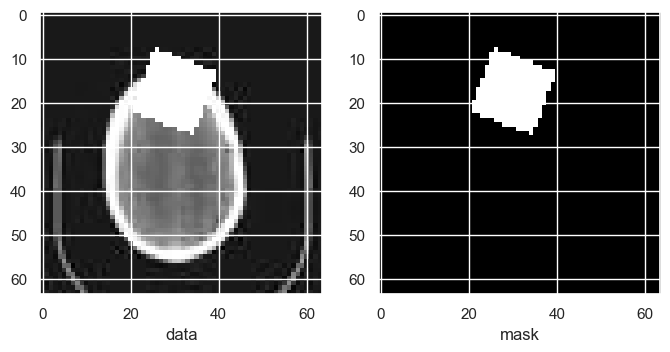

In [6]:
plt.subplots(1,3, figsize=(8, 8))

plt.subplot(1,2,1)
plt.xlabel(f"data")
plt.imshow(val_ds[101][0][0], cmap="gray", vmin=0, vmax=1)

plt.subplot(1,2,2)
plt.xlabel(f"mask")
plt.imshow(val_ds[101][1][0], cmap="gray", vmin=0, vmax=1)
plt.show()


In [7]:
#taken from the brainweb github code
#plan on cleaning this up because it is messy

def compute_dice_curve_recursive(predictions, labels, filename=None, plottitle="DICE Curve", granularity=5):
    scores, threshs = compute_dice_score(predictions, labels, granularity)

    best_score, best_threshold = sorted(zip(scores, threshs), reverse=True)[0]

    min_threshs, max_threshs = min(threshs), max(threshs)
    buffer_range = math.fabs(min_threshs - max_threshs) * 0.02
    x_min, x_max = min(threshs) - buffer_range, max(threshs) + buffer_range
    fig = plt.figure()
    plt.plot(threshs, scores, color='darkorange', lw=2, label='DICE vs Threshold Curve')
    plt.xlim([x_min, x_max])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Thresholds')
    plt.ylabel('DICE Score')
    plt.title(plottitle)
    plt.legend(loc="lower right")
    plt.text(x_max - x_max * 0.01, 1, f'Best dice score at {best_threshold:.5f} with {best_score:.4f}', horizontalalignment='right',
                           verticalalignment='top')
    #plt.show()

    # save a pdf to disk
    if filename:
        fig.savefig(filename)

        with open(filename + ".csv", mode="w") as csv_file:
            fieldnames = ["Thresholds", "DICE Score"]
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()
            for i in range(len(scores)):
                writer.writerow({fieldnames[0]: threshs[i], fieldnames[1]: scores[i]})
    plt.close(fig)

    bestthresh_idx = np.argmax(scores)
    return scores[bestthresh_idx], threshs[bestthresh_idx]

def dice(P, G):
    psum = np.sum(P.flatten())
    gsum = np.sum(G.flatten())
    pgsum = np.sum(np.multiply(P.flatten(), G.flatten()))
    score = (2 * pgsum) / (psum + gsum)
    #print(f"pgsum {pgsum}, psum {psum}, gsum {gsum}")
    return score

def xfrange(start, stop, step):
    i = 0
    while start + i * step < stop:
        yield start + i * step
        i += 1

def compute_dice_score(predictions, labels, granularity):
    def inner_compute_dice_curve_recursive(start, stop, decimal):
        _threshs = []
        _scores = []
        had_recursion = False

        if decimal == granularity:
            return _threshs, _scores

        for i, t in enumerate(xfrange(start, stop, (1.0 / (10.0 ** decimal)))):
            #print(f"Trying {i},{t}")
            score = dice(np.where(predictions > t, 1, 0), labels)
            if i >= 2 and score <= _scores[i - 1] and not had_recursion:
                _subthreshs, _subscores = inner_compute_dice_curve_recursive(_threshs[i - 2], t, decimal + 1)
                _threshs.extend(_subthreshs)
                _scores.extend(_subscores)
                had_recursion = True
            _scores.append(score)
            _threshs.append(t)

        return _threshs, _scores

    threshs, scores = inner_compute_dice_curve_recursive(0, 1.0, 1)
    sorted_pairs = sorted(zip(threshs, scores))
    threshs, scores = list(zip(*sorted_pairs))
    return scores, threshs

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import csv
def compute_prc(predictions, labels, filename=None, plottitle="Precision-Recall Curve"):
    precisions, recalls, thresholds = precision_recall_curve(labels.astype(int), predictions)
    auprc = average_precision_score(labels.astype(int), predictions)

    fig = plt.figure()
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'{plottitle} (area = {auprc:.2f}.)')
    #plt.show()

    # save a pdf to disk
    if filename:
        fig.savefig(filename)

        with open(filename + ".csv", mode="w") as csv_file:
            fieldnames = ["Precision", "Recall"]
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()
            for i in range(len(precisions)):
                writer.writerow({"Precision": precisions[i], "Recall": recalls[i]})
    plt.close(fig)

    return auprc, precisions, recalls, thresholds


def compute_roc(predictions, labels, filename=None, plottitle="ROC Curve"):
    _fpr, _tpr, _ = roc_curve(labels.astype(int), predictions)
    roc_auc = auc(_fpr, _tpr)

    fig = plt.figure()
    plt.plot(_fpr, _tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plottitle)
    plt.legend(loc="lower right")
    #plt.show()

    # save a pdf to disk
    if filename:
        fig.savefig(filename)

        with open(filename + ".csv", mode="w") as csv_file:
            fieldnames = ["False Positive Rate", "True Positive Rate"]
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()
            for i in range(len(_fpr)):
                writer.writerow({fieldnames[0]: _fpr[i], fieldnames[1]: _tpr[i]})
    plt.close(fig)

    return roc_auc, _fpr, _tpr, _

In [42]:
encoderdict={'num_layers': 3, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'dilation': 1}
from custommodels import AutoEnc
testmodel = AutoEnc(**encoderdict).to(device)

Layer 1 (channels 1 shape 64) -> 16, 64
Layer 2 (channels 16 shape 64) -> 32, 64
Layer 3 (channels 32 shape 64) -> 64, 64
Layer 1 (channels 64 shape 64) -> 64, 64
Layer 2 (channels 64 shape 64) -> 32, 64
Layer 3 (channels 32 shape 64) -> 16, 64


In [137]:
from custommodels import AutoEnc


encoderdict = dict()
encoderdict['num_layers'] = 4 #14
encoderdict['kernel_size'] = 5
encoderdict['stride'] = 1
encoderdict['padding'] = 0
encoderdict['dilation'] = 1
model = AutoEnc(**encoderdict).to(device)

Layer 1 (channels 1 shape 64) -> 16, 60
Layer 2 (channels 16 shape 60) -> 32, 56
Layer 3 (channels 32 shape 56) -> 64, 52
Layer 4 (channels 64 shape 52) -> 64, 48
Layer 5 (channels 64 shape 48) -> 64, 44
Layer 6 (channels 64 shape 44) -> 64, 40
Layer 7 (channels 64 shape 40) -> 64, 36
Layer 8 (channels 64 shape 36) -> 64, 32
Layer 9 (channels 64 shape 32) -> 64, 28
Layer 10 (channels 64 shape 28) -> 64, 24
Layer 11 (channels 64 shape 24) -> 64, 20
Layer 12 (channels 64 shape 20) -> 64, 16
Layer 13 (channels 64 shape 16) -> 64, 12
Layer 14 (channels 64 shape 12) -> 64, 8
Layer 1 (channels 64 shape 8) -> 64, 12
Layer 2 (channels 64 shape 12) -> 32, 16
Layer 3 (channels 32 shape 16) -> 16, 20
Layer 4 (channels 16 shape 20) -> 16, 24
Layer 5 (channels 16 shape 24) -> 16, 28
Layer 6 (channels 16 shape 28) -> 16, 32
Layer 7 (channels 16 shape 32) -> 16, 36
Layer 8 (channels 16 shape 36) -> 16, 40
Layer 9 (channels 16 shape 40) -> 16, 44
Layer 10 (channels 16 shape 44) -> 16, 48
Layer 11 (cha

In [8]:
def train(model,train_loader,optimizer,loss_function):
    model.train()
    epoch_loss = 0
    step = 0
    num_steps = len(train_loader)
    for batch_data, ground_truths in train_loader:
        step += 1
        inputs = batch_data.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = loss_function(outputs, inputs)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{num_steps}, "f"train_loss: {loss.item():.4f}")
        
        #if step >= 2:
        #    break
    epoch_loss /= step
    return epoch_loss

def score(model,loader,loss_function):
    model.eval()
    with torch.no_grad():
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        y_mask = torch.tensor([], dtype=torch.long, device=device)
        y_true = torch.tensor([], dtype=torch.long, device=device)
        loss_values = []
        for data, ground_truths in loader:
            val_images = data.to(device)
            y_pred = torch.cat([y_pred, model(val_images)], dim=0)
            y_true = torch.cat([y_true, val_images], dim=0)
            y_mask = torch.cat([y_mask, ground_truths], dim=0)
            loss = loss_function(y_pred, y_true)
            loss_values.append(loss.item())
        return loss_values, y_pred,y_mask,y_true

def metrics(pred,true,type,fol,filename):
    folder = "images"

    folder = os.path.join(folder,fol)
    if not os.path.exists(folder):
        os.makedirs(folder)

    diceScore,diceThreshold = compute_dice_curve_recursive(
        pred,true,
        plottitle=f"DICE vs L1 Threshold Curve for {type} Samples",
        filename=os.path.join(folder, f'dicePC_{filename}.png'),
        granularity=10
    )

    #print("Computing AUROC:")
    diff_auc, _fpr, _tpr, _threshs = compute_roc(pred.flatten(), true.astype(bool).flatten(),
                                                                    plottitle=f"ROC Curve for {type} Samples",
                                                                    filename=os.path.join(folder, f'rocPC_{filename}.png'))

    #print("Computing AUPRC:")
    diff_auprc, _precisions, _recalls, _threshs = compute_prc(
        pred.flatten(),
        true.astype(bool).flatten(),
        plottitle=f"Precision-Recall Curve for {type} Samples",
        filename=os.path.join(folder, f'prcPC_{filename}.png')
    )
    return diff_auc,diff_auprc,diceScore,diceThreshold

## LR_experiment

In [14]:
def objective(trial):
    best_metric=None
    max_epochs = 10
    val_interval = 1
    
    # Generate values
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    chosen_loss = "L1" #trial.suggest_categorical("chosen_loss", ["L1","L2"])
    gamma = 0 #trial.suggest_float("gamma",0,1,step=0.1)
    
    # Generate the model.

    encoderdict = dict()
    encoderdict['num_layers'] = 3#trial.suggest_int('num_layers',1,8) #15
    encoderdict['kernel_size'] = 3#trial.suggest_int('kernel_size',3,7)
    encoderdict['stride'] = 2  #trial.suggest_int('stride',0,2)
    encoderdict['padding'] = 0 #trial.suggest_int('padding',0,2)
    encoderdict['dilation'] = 1 #trial.suggest_int('dilation',0,2)
    try:
        print("making model...")
        #print(encoderdict)
        from custommodels import AutoEnc
        model = AutoEnc(**encoderdict).to(device)
    except Exception as e: 
        raise optuna.exceptions.TrialPruned()
    
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    if chosen_loss=="L1":
        loss_function = nn.L1Loss()
        score_function = nn.L1Loss(reduction='none')
    elif chosen_loss=="L2":
        loss_function = nn.MSELoss()
        score_function = nn.MSELoss(reduction='none')
    else:
        raise ValueError(f"chosen loss {chosen_loss} invalid")

    #get dataset
    train_ds = MedNISTDataset(train_x)
    train_loader = DataLoader(train_ds, batch_size=256,shuffle=True)

    val_ds = MedNISTDataset(val_x)
    val_loader = DataLoader(val_ds, batch_size=256)


    customname = f"{trial.number}-({lr},{gamma},{encoderdict['num_layers']},{encoderdict['kernel_size']},{encoderdict['stride']},{encoderdict['padding']},{encoderdict['dilation']},{chosen_loss})"
    modelfolder = "./models"
    if not os.path.exists(modelfolder):
        os.makedirs(modelfolder)
    
    val_losses = []
    train_losses = []
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        epoch_loss = train(model,train_loader,optimizer,loss_function)
        print(f"TRAIN: epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        train_losses.append(epoch_loss)
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                loss_values, y_pred,y_mask,y_true = score(model,val_loader,loss_function)
            
                y_stat = score_function(y_pred,y_true)


                y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask, detach=False)])
                #y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
                #y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred)])

                #reconstruction_err = np.sum(loss_values)
                avg_reconstruction_err = np.mean(loss_values)
                val_losses.append(avg_reconstruction_err)
                if best_metric == None or avg_reconstruction_err < best_metric:
                    best_metric = avg_reconstruction_err
                    best_metric_epoch = epoch + 1
                

                #print(np.unique(y_stat),np.unique(y_mask_np))
                #print("min",torch.min(y_stat),"max",torch.max(y_stat))
                diff_auc,diff_auprc,diceScore,diceThreshold = metrics(y_stat,y_mask_np,"Validation",customname,str(epoch+1))
                scheduler.step()
                print(
                    f"current epoch: {epoch + 1}",
                    f"\ncurrent L1 reconstruction error mean: {avg_reconstruction_err:.4f}",
                    f"\nAUROC: {diff_auc:.4f}",
                    f"\nAUPRC: {diff_auprc:.4f}",
                    f"\nDICE score: {diceScore:.4f}",
                    f"\nThreshold: {diceThreshold:.4f}",
                    f"\nbest L1 reconstruction error mean: {best_metric:.4f} at epoch: {best_metric_epoch}"
                )
                trial.report(avg_reconstruction_err, epoch+1)
                # Handle pruning based on the intermediate value.
                if trial.should_prune():
                   #train
                    mname = f'trainRecErr.png'
                    folder = './images'
                    folder = os.path.join(folder,customname)
                    if not os.path.exists(folder):
                        os.makedirs(folder)
                    fig = plt.figure()
                    eplen = range(1,epoch+2)
                    plt.plot(eplen,train_losses, color='darkorange', lw=2)
                    plt.xlabel('Epochs')
                    plt.ylabel(f'{chosen_loss}')
                    plt.title(f'Avg Train Reconstruction Error ({chosen_loss})')
                    #plt.show()
                    # save a pdf to disk
                    fig.savefig(os.path.join(folder,mname))
                    
                    with open(os.path.join(folder,mname) + ".csv", mode="w") as csv_file:
                        fieldnames = ["Epochs", f"{chosen_loss}"]
                        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                        writer.writeheader()
                        for i in range(len(train_losses)):
                            writer.writerow({fieldnames[0]: eplen[i], fieldnames[1]: train_losses[i]})
                    plt.close(fig)
                    #val
                    mname = f'valRecErr.png'
                    folder = './images'
                    folder = os.path.join(folder,customname)
                    if not os.path.exists(folder):
                        os.makedirs(folder)
                    fig = plt.figure()
                    eplen = range(1,epoch+2)
                    plt.plot(eplen,val_losses, color='darkorange', lw=2)
                    plt.xlabel('Epochs')
                    plt.ylabel(f'{chosen_loss}')
                    plt.title(f'Avg Val Reconstruction Error ({chosen_loss})')
                    #plt.show()
                    # save a pdf to disk
                    fig.savefig(os.path.join(folder,mname))

                    print(f"train completed, best_metric: {best_metric:.4f} "f"at epoch: {best_metric_epoch}")
                    modelsavedloc = os.path.join(modelfolder,f"ae_model_{customname}.pth")
                    torch.save(model.state_dict(), modelsavedloc)
                    print(f"Saved model at {modelsavedloc}.")
                    raise optuna.exceptions.TrialPruned()
    #filename
    #train
    mname = f'trainRecErr.png'
    folder = './images'
    folder = os.path.join(folder,customname)
    if not os.path.exists(folder):
        os.makedirs(folder)
    fig = plt.figure()
    eplen = range(1,epoch+2)
    plt.plot(eplen,train_losses, color='darkorange', lw=2)
    plt.xlabel('Epochs')
    plt.ylabel(f'{chosen_loss}')
    plt.title(f'Avg Train Reconstruction Error ({chosen_loss})')
    #plt.show()
    # save a pdf to disk
    fig.savefig(os.path.join(folder,mname))
    
    with open(os.path.join(folder,mname) + ".csv", mode="w") as csv_file:
        fieldnames = ["Epochs", f"{chosen_loss}"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(len(train_losses)):
            writer.writerow({fieldnames[0]: eplen[i], fieldnames[1]: train_losses[i]})
    plt.close(fig)
    #val
    mname = f'valRecErr.png'
    folder = './images'
    folder = os.path.join(folder,customname)
    if not os.path.exists(folder):
        os.makedirs(folder)
    fig = plt.figure()
    eplen = range(1,epoch+2)
    plt.plot(eplen,val_losses, color='darkorange', lw=2)
    plt.xlabel('Epochs')
    plt.ylabel(f'{chosen_loss}')
    plt.title(f'Avg Val Reconstruction Error ({chosen_loss})')
    #plt.show()
    # save a pdf to disk
    fig.savefig(os.path.join(folder,mname))
    
    with open(os.path.join(folder,mname) + ".csv", mode="w") as csv_file:
        fieldnames = ["Epochs", f"{chosen_loss}"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(len(val_losses)):
            writer.writerow({fieldnames[0]: eplen[i], fieldnames[1]: val_losses[i]})
    plt.close(fig)

    print(f"train completed, best_metric: {best_metric:.4f} "f"at epoch: {best_metric_epoch}")
    modelsavedloc = os.path.join(modelfolder,f"ae_model_{customname}.pth")
    torch.save(model.state_dict(), modelsavedloc)
    print(f"Saved model at {modelsavedloc}.")

    return best_metric

In [ ]:
def objective(trial, arg1, arg2):
     """
     An objective function that accepts multiple parameters.
     """
     pass

# Generate values
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    chosen_loss = "L1" #trial.suggest_categorical("chosen_loss", ["L1","L2"])
    gamma = 0 #trial.suggest_float("gamma",0,1,step=0.1)
    
    # Generate the model.

    encoderdict = dict()
    encoderdict['num_layers'] = 3#trial.suggest_int('num_layers',1,8) #15
    encoderdict['kernel_size'] = 3#trial.suggest_int('kernel_size',3,7)
    encoderdict['stride'] = 2  #trial.suggest_int('stride',0,2)
    encoderdict['padding'] = 0 #trial.suggest_int('padding',0,2)
    encoderdict['dilation'] = 1 #trial.suggest_int('dilation',0,2)


# Wrap the objective inside a lambda and call objective inside it
func = lambda trial: objective(trial,)

# Pass func to Optuna studies
study = optuna.create_study(direction='minimize')
study.optimize(func, n_trials=100)

In [15]:
study = optuna.create_study(direction="minimize",study_name="lr_experiment")

study.optimize(objective, n_trials=30,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-11-22 10:44:01,068] A new study created in memory with name: lr_experiment


making model...
----------
epoch 1/10
1/24, train_loss: 0.5734
2/24, train_loss: 0.4572
3/24, train_loss: 0.2668
4/24, train_loss: 0.1835
5/24, train_loss: 0.1584
6/24, train_loss: 0.2127
7/24, train_loss: 0.2404
8/24, train_loss: 0.1997
9/24, train_loss: 0.1564
10/24, train_loss: 0.1931
11/24, train_loss: 0.1504
12/24, train_loss: 0.1336
13/24, train_loss: 0.1292
14/24, train_loss: 0.1287
15/24, train_loss: 0.1362
16/24, train_loss: 0.1205
17/24, train_loss: 0.1235
18/24, train_loss: 0.1188
19/24, train_loss: 0.1115
20/24, train_loss: 0.1079
21/24, train_loss: 0.1115
22/24, train_loss: 0.1125
23/24, train_loss: 0.1125
24/24, train_loss: 0.1141
TRAIN: epoch 1 average loss: 0.1813
current epoch: 1 
current L1 reconstruction error mean: 0.1375 
AUROC: 0.8805 
AUPRC: 0.0809 
DICE score: 0.1867 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1375 at epoch: 1
----------
epoch 2/10
1/24, train_loss: 0.1063
2/24, train_loss: 0.1094
3/24, train_loss: 0.1075
4/24, train_loss: 0.1052
5/

[I 2022-11-22 10:51:18,303] Trial 0 finished with value: 0.11937695648521185 and parameters: {'lr': 0.020951637803487314}. Best is trial 0 with value: 0.11937695648521185.


current epoch: 10 
current L1 reconstruction error mean: 0.1196 
AUROC: 0.9248 
AUPRC: 0.1456 
DICE score: 0.2372 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1194 at epoch: 3
train completed, best_metric: 0.1194 at epoch: 3
Saved model at ./models\ae_model_0-(0.020951637803487314,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.2768
2/24, train_loss: 0.2792
3/24, train_loss: 0.1484
4/24, train_loss: 0.1260
5/24, train_loss: 0.1272
6/24, train_loss: 0.1132
7/24, train_loss: 0.1095
8/24, train_loss: 0.1031
9/24, train_loss: 0.1016
10/24, train_loss: 0.1014
11/24, train_loss: 0.1006
12/24, train_loss: 0.0978
13/24, train_loss: 0.0982
14/24, train_loss: 0.0982
15/24, train_loss: 0.0951
16/24, train_loss: 0.0927
17/24, train_loss: 0.0941
18/24, train_loss: 0.0928
19/24, train_loss: 0.0904
20/24, train_loss: 0.0896
21/24, train_loss: 0.0919
22/24, train_loss: 0.0919
23/24, train_loss: 0.0902
24/24, train_loss: 0.0939
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 11:00:46,521] Trial 1 finished with value: 0.09896540362387896 and parameters: {'lr': 0.007495047772469976}. Best is trial 1 with value: 0.09896540362387896.


current epoch: 10 
current L1 reconstruction error mean: 0.0990 
AUROC: 0.9486 
AUPRC: 0.2241 
DICE score: 0.2500 
Threshold: 0.7490 
best L1 reconstruction error mean: 0.0990 at epoch: 5
train completed, best_metric: 0.0990 at epoch: 5
Saved model at ./models\ae_model_1-(0.007495047772469976,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.2768
2/24, train_loss: 0.2491
3/24, train_loss: 0.1745
4/24, train_loss: 0.1389
5/24, train_loss: 0.1229
6/24, train_loss: 0.1201
7/24, train_loss: 0.1121
8/24, train_loss: 0.1098
9/24, train_loss: 0.1029
10/24, train_loss: 0.1054
11/24, train_loss: 0.1019
12/24, train_loss: 0.0987
13/24, train_loss: 0.0998
14/24, train_loss: 0.0985
15/24, train_loss: 0.0972
16/24, train_loss: 0.0927
17/24, train_loss: 0.0939
18/24, train_loss: 0.0922
19/24, train_loss: 0.0890
20/24, train_loss: 0.0905
21/24, train_loss: 0.0907
22/24, train_loss: 0.0904
23/24, train_loss: 0.0903
24/24, train_loss: 0.0920
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 11:10:42,741] Trial 2 finished with value: 0.09833195991814137 and parameters: {'lr': 0.0032549301383549964}. Best is trial 2 with value: 0.09833195991814137.


current epoch: 10 
current L1 reconstruction error mean: 0.0983 
AUROC: 0.9492 
AUPRC: 0.2313 
DICE score: 0.2475 
Threshold: 0.7500 
best L1 reconstruction error mean: 0.0983 at epoch: 5
train completed, best_metric: 0.0983 at epoch: 5
Saved model at ./models\ae_model_2-(0.0032549301383549964,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.2768
2/24, train_loss: 0.2729
3/24, train_loss: 0.2717
4/24, train_loss: 0.2678
5/24, train_loss: 0.2667
6/24, train_loss: 0.2636
7/24, train_loss: 0.2604
8/24, train_loss: 0.2585
9/24, train_loss: 0.2553
10/24, train_loss: 0.2548
11/24, train_loss: 0.2515
12/24, train_loss: 0.2497
13/24, train_loss: 0.2485
14/24, train_loss: 0.2460
15/24, train_loss: 0.2430
16/24, train_loss: 0.2402
17/24, train_loss: 0.2420
18/24, train_loss: 0.2384
19/24, train_loss: 0.2364
20/24, train_loss: 0.2357
21/24, train_loss: 0.2339
22/24, train_loss: 0.2334
23/24, train_loss: 0.2305
24/24, train_loss: 0.2324
TRAIN: epoch 1 average loss: 0.

[I 2022-11-22 11:21:47,869] Trial 3 finished with value: 0.17512159794569016 and parameters: {'lr': 2.7167572655139717e-05}. Best is trial 2 with value: 0.09833195991814137.


current epoch: 10 
current L1 reconstruction error mean: 0.2372 
AUROC: 0.9222 
AUPRC: 0.1308 
DICE score: 0.2275 
Threshold: 0.7410 
best L1 reconstruction error mean: 0.1751 at epoch: 1
train completed, best_metric: 0.1751 at epoch: 1
Saved model at ./models\ae_model_3-(2.7167572655139717e-05,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.2768
2/24, train_loss: 0.2358
3/24, train_loss: 0.2002
4/24, train_loss: 0.1741
5/24, train_loss: 0.1543
6/24, train_loss: 0.1376
7/24, train_loss: 0.1263
8/24, train_loss: 0.1185
9/24, train_loss: 0.1141
10/24, train_loss: 0.1109
11/24, train_loss: 0.1095
12/24, train_loss: 0.1060
13/24, train_loss: 0.1038
14/24, train_loss: 0.1034
15/24, train_loss: 0.0993
16/24, train_loss: 0.0954
17/24, train_loss: 0.0968
18/24, train_loss: 0.0939
19/24, train_loss: 0.0912
20/24, train_loss: 0.0912
21/24, train_loss: 0.0916
22/24, train_loss: 0.0911
23/24, train_loss: 0.0902
24/24, train_loss: 0.0922
TRAIN: epoch 1 average loss: 0

[I 2022-11-22 11:31:56,444] Trial 4 finished with value: 0.0967048816382885 and parameters: {'lr': 0.001341399398779975}. Best is trial 4 with value: 0.0967048816382885.


current epoch: 10 
current L1 reconstruction error mean: 0.0967 
AUROC: 0.9305 
AUPRC: 0.1935 
DICE score: 0.2231 
Threshold: 0.7190 
best L1 reconstruction error mean: 0.0967 at epoch: 3
train completed, best_metric: 0.0967 at epoch: 3
Saved model at ./models\ae_model_4-(0.001341399398779975,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.2768
2/24, train_loss: 0.2512
3/24, train_loss: 0.1711
4/24, train_loss: 0.1366
5/24, train_loss: 0.1215
6/24, train_loss: 0.1196
7/24, train_loss: 0.1110
8/24, train_loss: 0.1090
9/24, train_loss: 0.1017
10/24, train_loss: 0.1047
11/24, train_loss: 0.1006
12/24, train_loss: 0.0993
13/24, train_loss: 0.0996
14/24, train_loss: 0.0989
15/24, train_loss: 0.0971
16/24, train_loss: 0.0921
17/24, train_loss: 0.0943
18/24, train_loss: 0.0918
19/24, train_loss: 0.0889
20/24, train_loss: 0.0905
21/24, train_loss: 0.0901
22/24, train_loss: 0.0909
23/24, train_loss: 0.0906
24/24, train_loss: 0.0923
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 11:41:53,077] Trial 5 finished with value: 0.0982753150165081 and parameters: {'lr': 0.0036199803255028756}. Best is trial 4 with value: 0.0967048816382885.


current epoch: 10 
current L1 reconstruction error mean: 0.0983 
AUROC: 0.9499 
AUPRC: 0.2324 
DICE score: 0.2491 
Threshold: 0.7640 
best L1 reconstruction error mean: 0.0983 at epoch: 9
train completed, best_metric: 0.0983 at epoch: 9
Saved model at ./models\ae_model_5-(0.0036199803255028756,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.2768
2/24, train_loss: 0.2553
3/24, train_loss: 0.2417
4/24, train_loss: 0.2294
5/24, train_loss: 0.2210
6/24, train_loss: 0.2128
7/24, train_loss: 0.2043
8/24, train_loss: 0.1983
9/24, train_loss: 0.1915
10/24, train_loss: 0.1866
11/24, train_loss: 0.1789
12/24, train_loss: 0.1727
13/24, train_loss: 0.1684
14/24, train_loss: 0.1623
15/24, train_loss: 0.1570
16/24, train_loss: 0.1509
17/24, train_loss: 0.1494
18/24, train_loss: 0.1435
19/24, train_loss: 0.1386
20/24, train_loss: 0.1353
21/24, train_loss: 0.1321
22/24, train_loss: 0.1295
23/24, train_loss: 0.1265
24/24, train_loss: 0.1267
TRAIN: epoch 1 average loss: 0.

[I 2022-11-22 11:42:36,686] Trial 6 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1604 
AUROC: 0.9801 
AUPRC: 0.2641 
DICE score: 0.3749 
Threshold: 0.8629 
best L1 reconstruction error mean: 0.1604 at epoch: 1
train completed, best_metric: 0.1604 at epoch: 1
Saved model at ./models\ae_model_6-(0.000229291674540275,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.2866
3/24, train_loss: 0.1978
4/24, train_loss: 0.1599
5/24, train_loss: 0.1416
6/24, train_loss: 0.1236
7/24, train_loss: 0.1151
8/24, train_loss: 0.1100
9/24, train_loss: 0.1055
10/24, train_loss: 0.1053
11/24, train_loss: 0.1035
12/24, train_loss: 0.1012
13/24, train_loss: 0.1007
14/24, train_loss: 0.1013
15/24, train_loss: 0.0995
16/24, train_loss: 0.0962
17/24, train_loss: 0.1000
18/24, train_loss: 0.0959
19/24, train_loss: 0.0941
20/24, train_loss: 0.0948
21/24, train_loss: 0.0922
22/24, train_loss: 0.0943
23/24, train_loss: 0.0927
24/24, train_loss: 0.0979
TRAIN: epoch 1 average loss: 0.12

[I 2022-11-22 11:44:40,547] Trial 7 pruned. 


current epoch: 2 
current L1 reconstruction error mean: 0.1089 
AUROC: 0.9570 
AUPRC: 0.2285 
DICE score: 0.2522 
Threshold: 0.8000 
best L1 reconstruction error mean: 0.1089 at epoch: 2
train completed, best_metric: 0.1089 at epoch: 2
Saved model at ./models\ae_model_7-(0.0035552689597321847,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3803
2/24, train_loss: 0.3418
3/24, train_loss: 0.2474
4/24, train_loss: 0.1704
5/24, train_loss: 0.1431
6/24, train_loss: 0.1280
7/24, train_loss: 0.1175
8/24, train_loss: 0.1123
9/24, train_loss: 0.1103
10/24, train_loss: 0.1130
11/24, train_loss: 0.1137
12/24, train_loss: 0.1134
13/24, train_loss: 0.1125
14/24, train_loss: 0.1077
15/24, train_loss: 0.1009
16/24, train_loss: 0.1031
17/24, train_loss: 0.1037
18/24, train_loss: 0.0997
19/24, train_loss: 0.0977
20/24, train_loss: 0.0927
21/24, train_loss: 0.0950
22/24, train_loss: 0.0949
23/24, train_loss: 0.0948
24/24, train_loss: 0.0969
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 11:46:39,228] Trial 8 pruned. 


current epoch: 2 
current L1 reconstruction error mean: 0.1070 
AUROC: 0.9602 
AUPRC: 0.2270 
DICE score: 0.2531 
Threshold: 0.8000 
best L1 reconstruction error mean: 0.1070 at epoch: 2
train completed, best_metric: 0.1070 at epoch: 2
Saved model at ./models\ae_model_8-(0.004941279266019157,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3803
2/24, train_loss: 0.3757
3/24, train_loss: 0.3758
4/24, train_loss: 0.3684
5/24, train_loss: 0.3691
6/24, train_loss: 0.3624
7/24, train_loss: 0.3622
8/24, train_loss: 0.3566
9/24, train_loss: 0.3538
10/24, train_loss: 0.3505
11/24, train_loss: 0.3525
12/24, train_loss: 0.3494
13/24, train_loss: 0.3449
14/24, train_loss: 0.3458
15/24, train_loss: 0.3412
16/24, train_loss: 0.3360
17/24, train_loss: 0.3385
18/24, train_loss: 0.3351
19/24, train_loss: 0.3282
20/24, train_loss: 0.3248
21/24, train_loss: 0.3244
22/24, train_loss: 0.3256
23/24, train_loss: 0.3253
24/24, train_loss: 0.3265
TRAIN: epoch 1 average loss: 0.34

[I 2022-11-22 11:47:06,833] Trial 9 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.2082 
AUROC: 0.9788 
AUPRC: 0.2449 
DICE score: 0.3587 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.2082 at epoch: 1
train completed, best_metric: 0.2082 at epoch: 1
Saved model at ./models\ae_model_9-(2.1875721739229104e-05,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.3100
3/24, train_loss: 0.2254
4/24, train_loss: 0.2083
5/24, train_loss: 0.1650
6/24, train_loss: 0.1559
7/24, train_loss: 0.1542
8/24, train_loss: 0.1452
9/24, train_loss: 0.1333
10/24, train_loss: 0.1344
11/24, train_loss: 0.1298
12/24, train_loss: 0.1277
13/24, train_loss: 0.1275
14/24, train_loss: 0.1254
15/24, train_loss: 0.1224
16/24, train_loss: 0.1191
17/24, train_loss: 0.1204
18/24, train_loss: 0.1148
19/24, train_loss: 0.1157
20/24, train_loss: 0.1083
21/24, train_loss: 0.1119
22/24, train_loss: 0.1139
23/24, train_loss: 0.1085
24/24, train_loss: 0.1189
TRAIN: epoch 1 average loss: 0.

[I 2022-11-22 11:48:12,125] Trial 10 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.5059 
AUROC: 0.8467 
AUPRC: 0.0503 
DICE score: 0.0902 
Threshold: 0.6400 
best L1 reconstruction error mean: 0.5059 at epoch: 1
train completed, best_metric: 0.5059 at epoch: 1
Saved model at ./models\ae_model_10-(0.09754947113831433,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.2711
3/24, train_loss: 0.2430
4/24, train_loss: 0.2191
5/24, train_loss: 0.2075
6/24, train_loss: 0.1944
7/24, train_loss: 0.1856
8/24, train_loss: 0.1762
9/24, train_loss: 0.1698
10/24, train_loss: 0.1668
11/24, train_loss: 0.1640
12/24, train_loss: 0.1607
13/24, train_loss: 0.1574
14/24, train_loss: 0.1564
15/24, train_loss: 0.1524
16/24, train_loss: 0.1470
17/24, train_loss: 0.1495
18/24, train_loss: 0.1456
19/24, train_loss: 0.1400
20/24, train_loss: 0.1375
21/24, train_loss: 0.1361
22/24, train_loss: 0.1362
23/24, train_loss: 0.1339
24/24, train_loss: 0.1358
TRAIN: epoch 1 average loss: 0.17

[I 2022-11-22 11:48:54,384] Trial 11 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1610 
AUROC: 0.9797 
AUPRC: 0.2640 
DICE score: 0.3717 
Threshold: 0.8502 
best L1 reconstruction error mean: 0.1610 at epoch: 1
train completed, best_metric: 0.1610 at epoch: 1
Saved model at ./models\ae_model_11-(0.00035771679501604264,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.2590
3/24, train_loss: 0.2286
4/24, train_loss: 0.2053
5/24, train_loss: 0.1939
6/24, train_loss: 0.1806
7/24, train_loss: 0.1728
8/24, train_loss: 0.1659
9/24, train_loss: 0.1610
10/24, train_loss: 0.1586
11/24, train_loss: 0.1561
12/24, train_loss: 0.1528
13/24, train_loss: 0.1491
14/24, train_loss: 0.1476
15/24, train_loss: 0.1428
16/24, train_loss: 0.1366
17/24, train_loss: 0.1385
18/24, train_loss: 0.1344
19/24, train_loss: 0.1292
20/24, train_loss: 0.1261
21/24, train_loss: 0.1246
22/24, train_loss: 0.1240
23/24, train_loss: 0.1217
24/24, train_loss: 0.1226
TRAIN: epoch 1 average loss: 0

[I 2022-11-22 11:49:37,279] Trial 12 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1581 
AUROC: 0.9790 
AUPRC: 0.2574 
DICE score: 0.3635 
Threshold: 0.8360 
best L1 reconstruction error mean: 0.1581 at epoch: 1
train completed, best_metric: 0.1581 at epoch: 1
Saved model at ./models\ae_model_12-(0.0005062808184614126,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.2458
3/24, train_loss: 0.2045
4/24, train_loss: 0.1737
5/24, train_loss: 0.1647
6/24, train_loss: 0.1559
7/24, train_loss: 0.1490
8/24, train_loss: 0.1406
9/24, train_loss: 0.1317
10/24, train_loss: 0.1282
11/24, train_loss: 0.1238
12/24, train_loss: 0.1179
13/24, train_loss: 0.1146
14/24, train_loss: 0.1126
15/24, train_loss: 0.1083
16/24, train_loss: 0.1043
17/24, train_loss: 0.1054
18/24, train_loss: 0.1015
19/24, train_loss: 0.0977
20/24, train_loss: 0.0970
21/24, train_loss: 0.0969
22/24, train_loss: 0.0969
23/24, train_loss: 0.0959
24/24, train_loss: 0.0980
TRAIN: epoch 1 average loss: 0.

[I 2022-11-22 11:50:24,182] Trial 13 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1289 
AUROC: 0.9660 
AUPRC: 0.2279 
DICE score: 0.2634 
Threshold: 0.6140 
best L1 reconstruction error mean: 0.1289 at epoch: 1
train completed, best_metric: 0.1289 at epoch: 1
Saved model at ./models\ae_model_13-(0.001576678706785159,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.4494
3/24, train_loss: 0.2043
4/24, train_loss: 0.1391
5/24, train_loss: 0.1301
6/24, train_loss: 0.1225
7/24, train_loss: 0.1147
8/24, train_loss: 0.1117
9/24, train_loss: 0.1089
10/24, train_loss: 0.1107
11/24, train_loss: 0.1109
12/24, train_loss: 0.1104
13/24, train_loss: 0.1075
14/24, train_loss: 0.1071
15/24, train_loss: 0.1082
16/24, train_loss: 0.1060
17/24, train_loss: 0.1048
18/24, train_loss: 0.1026
19/24, train_loss: 0.1006
20/24, train_loss: 0.0986
21/24, train_loss: 0.1014
22/24, train_loss: 0.1039
23/24, train_loss: 0.1006
24/24, train_loss: 0.1071
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 11:51:28,562] Trial 14 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.3722 
AUROC: 0.7794 
AUPRC: 0.0284 
DICE score: 0.0650 
Threshold: 0.4850 
best L1 reconstruction error mean: 0.3722 at epoch: 1
train completed, best_metric: 0.3722 at epoch: 1
Saved model at ./models\ae_model_14-(0.02458733953388758,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.3031
3/24, train_loss: 0.2928
4/24, train_loss: 0.2782
5/24, train_loss: 0.2710
6/24, train_loss: 0.2591
7/24, train_loss: 0.2512
8/24, train_loss: 0.2421
9/24, train_loss: 0.2340
10/24, train_loss: 0.2284
11/24, train_loss: 0.2236
12/24, train_loss: 0.2179
13/24, train_loss: 0.2125
14/24, train_loss: 0.2095
15/24, train_loss: 0.2034
16/24, train_loss: 0.1973
17/24, train_loss: 0.1981
18/24, train_loss: 0.1934
19/24, train_loss: 0.1871
20/24, train_loss: 0.1841
21/24, train_loss: 0.1822
22/24, train_loss: 0.1818
23/24, train_loss: 0.1792
24/24, train_loss: 0.1813
TRAIN: epoch 1 average loss: 0.22

[I 2022-11-22 11:52:10,644] Trial 15 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1720 
AUROC: 0.9787 
AUPRC: 0.2524 
DICE score: 0.3635 
Threshold: 0.8378 
best L1 reconstruction error mean: 0.1720 at epoch: 1
train completed, best_metric: 0.1720 at epoch: 1
Saved model at ./models\ae_model_15-(9.039804099001368e-05,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.2418
3/24, train_loss: 0.2076
4/24, train_loss: 0.1808
5/24, train_loss: 0.1702
6/24, train_loss: 0.1611
7/24, train_loss: 0.1564
8/24, train_loss: 0.1499
9/24, train_loss: 0.1435
10/24, train_loss: 0.1388
11/24, train_loss: 0.1343
12/24, train_loss: 0.1296
13/24, train_loss: 0.1255
14/24, train_loss: 0.1232
15/24, train_loss: 0.1177
16/24, train_loss: 0.1123
17/24, train_loss: 0.1134
18/24, train_loss: 0.1089
19/24, train_loss: 0.1045
20/24, train_loss: 0.1029
21/24, train_loss: 0.1020
22/24, train_loss: 0.1017
23/24, train_loss: 0.1006
24/24, train_loss: 0.1021
TRAIN: epoch 1 average loss: 0.

[I 2022-11-22 11:52:55,447] Trial 16 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1350 
AUROC: 0.9699 
AUPRC: 0.2395 
DICE score: 0.2839 
Threshold: 0.6480 
best L1 reconstruction error mean: 0.1350 at epoch: 1
train completed, best_metric: 0.1350 at epoch: 1
Saved model at ./models\ae_model_16-(0.0011565275745782175,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.2972
3/24, train_loss: 0.2823
4/24, train_loss: 0.2641
5/24, train_loss: 0.2546
6/24, train_loss: 0.2409
7/24, train_loss: 0.2317
8/24, train_loss: 0.2218
9/24, train_loss: 0.2137
10/24, train_loss: 0.2085
11/24, train_loss: 0.2038
12/24, train_loss: 0.1983
13/24, train_loss: 0.1932
14/24, train_loss: 0.1902
15/24, train_loss: 0.1843
16/24, train_loss: 0.1781
17/24, train_loss: 0.1795
18/24, train_loss: 0.1753
19/24, train_loss: 0.1697
20/24, train_loss: 0.1674
21/24, train_loss: 0.1662
22/24, train_loss: 0.1665
23/24, train_loss: 0.1644
24/24, train_loss: 0.1674
TRAIN: epoch 1 average loss: 0.

[I 2022-11-22 11:53:39,179] Trial 17 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1692 
AUROC: 0.9790 
AUPRC: 0.2571 
DICE score: 0.3678 
Threshold: 0.8501 
best L1 reconstruction error mean: 0.1692 at epoch: 1
train completed, best_metric: 0.1692 at epoch: 1
Saved model at ./models\ae_model_17-(0.00013272356597809329,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.4434
3/24, train_loss: 0.2003
4/24, train_loss: 0.1409
5/24, train_loss: 0.1258
6/24, train_loss: 0.1260
7/24, train_loss: 0.1184
8/24, train_loss: 0.1131
9/24, train_loss: 0.1099
10/24, train_loss: 0.1081
11/24, train_loss: 0.1093
12/24, train_loss: 0.1070
13/24, train_loss: 0.1067
14/24, train_loss: 0.1076
15/24, train_loss: 0.1017
16/24, train_loss: 0.1001
17/24, train_loss: 0.1032
18/24, train_loss: 0.1007
19/24, train_loss: 0.1000
20/24, train_loss: 0.0990
21/24, train_loss: 0.0993
22/24, train_loss: 0.1015
23/24, train_loss: 0.0999
24/24, train_loss: 0.1030
TRAIN: epoch 1 average loss: 0

[I 2022-11-22 11:54:43,388] Trial 18 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.2084 
AUROC: 0.7753 
AUPRC: 0.0294 
DICE score: 0.0611 
Threshold: 0.2600 
best L1 reconstruction error mean: 0.2084 at epoch: 1
train completed, best_metric: 0.2084 at epoch: 1
Saved model at ./models\ae_model_18-(0.01967840703909976,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.2448
3/24, train_loss: 0.2049
4/24, train_loss: 0.1747
5/24, train_loss: 0.1653
6/24, train_loss: 0.1568
7/24, train_loss: 0.1502
8/24, train_loss: 0.1423
9/24, train_loss: 0.1335
10/24, train_loss: 0.1295
11/24, train_loss: 0.1255
12/24, train_loss: 0.1197
13/24, train_loss: 0.1160
14/24, train_loss: 0.1139
15/24, train_loss: 0.1094
16/24, train_loss: 0.1053
17/24, train_loss: 0.1064
18/24, train_loss: 0.1024
19/24, train_loss: 0.0985
20/24, train_loss: 0.0977
21/24, train_loss: 0.0974
22/24, train_loss: 0.0974
23/24, train_loss: 0.0963
24/24, train_loss: 0.0983
TRAIN: epoch 1 average loss: 0.13

[I 2022-11-22 11:55:30,039] Trial 19 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1307 
AUROC: 0.9669 
AUPRC: 0.2330 
DICE score: 0.2678 
Threshold: 0.6220 
best L1 reconstruction error mean: 0.1307 at epoch: 1
train completed, best_metric: 0.1307 at epoch: 1
Saved model at ./models\ae_model_19-(0.0015098829667819578,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.3465
3/24, train_loss: 0.1926
4/24, train_loss: 0.1715
5/24, train_loss: 0.1584
6/24, train_loss: 0.1511
7/24, train_loss: 0.1509
8/24, train_loss: 0.1352
9/24, train_loss: 0.1427
10/24, train_loss: 0.1389
11/24, train_loss: 0.1346
12/24, train_loss: 0.1331
13/24, train_loss: 0.1284
14/24, train_loss: 0.1244
15/24, train_loss: 0.1273
16/24, train_loss: 0.1199
17/24, train_loss: 0.1150
18/24, train_loss: 0.1157
19/24, train_loss: 0.1082
20/24, train_loss: 0.1072
21/24, train_loss: 0.1098
22/24, train_loss: 0.1087
23/24, train_loss: 0.1086
24/24, train_loss: 0.1085
TRAIN: epoch 1 average loss: 0.

[I 2022-11-22 11:56:44,671] Trial 20 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.5215 
AUROC: 0.8022 
AUPRC: 0.0365 
DICE score: 0.0719 
Threshold: 0.6200 
best L1 reconstruction error mean: 0.5215 at epoch: 1
train completed, best_metric: 0.5215 at epoch: 1
Saved model at ./models\ae_model_20-(0.07947044816120005,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.2893
3/24, train_loss: 0.1971
4/24, train_loss: 0.1586
5/24, train_loss: 0.1397
6/24, train_loss: 0.1224
7/24, train_loss: 0.1142
8/24, train_loss: 0.1097
9/24, train_loss: 0.1050
10/24, train_loss: 0.1047
11/24, train_loss: 0.1036
12/24, train_loss: 0.1011
13/24, train_loss: 0.1005
14/24, train_loss: 0.1007
15/24, train_loss: 0.0992
16/24, train_loss: 0.0957
17/24, train_loss: 0.0998
18/24, train_loss: 0.0953
19/24, train_loss: 0.0941
20/24, train_loss: 0.0943
21/24, train_loss: 0.0927
22/24, train_loss: 0.0942
23/24, train_loss: 0.0923
24/24, train_loss: 0.0980
TRAIN: epoch 1 average loss: 0.12

[I 2022-11-22 11:58:44,876] Trial 21 pruned. 


current epoch: 2 
current L1 reconstruction error mean: 0.1078 
AUROC: 0.9565 
AUPRC: 0.2283 
DICE score: 0.2525 
Threshold: 0.8000 
best L1 reconstruction error mean: 0.1078 at epoch: 2
train completed, best_metric: 0.1078 at epoch: 2
Saved model at ./models\ae_model_21-(0.003686701881289876,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3803
2/24, train_loss: 0.3185
3/24, train_loss: 0.2862
4/24, train_loss: 0.2570
5/24, train_loss: 0.2394
6/24, train_loss: 0.2164
7/24, train_loss: 0.2032
8/24, train_loss: 0.1861
9/24, train_loss: 0.1740
10/24, train_loss: 0.1656
11/24, train_loss: 0.1603
12/24, train_loss: 0.1529
13/24, train_loss: 0.1472
14/24, train_loss: 0.1468
15/24, train_loss: 0.1421
16/24, train_loss: 0.1357
17/24, train_loss: 0.1370
18/24, train_loss: 0.1322
19/24, train_loss: 0.1266
20/24, train_loss: 0.1232
21/24, train_loss: 0.1216
22/24, train_loss: 0.1205
23/24, train_loss: 0.1181
24/24, train_loss: 0.1186
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 11:59:28,279] Trial 22 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1624 
AUROC: 0.9780 
AUPRC: 0.2459 
DICE score: 0.3507 
Threshold: 0.8601 
best L1 reconstruction error mean: 0.1624 at epoch: 1
train completed, best_metric: 0.1624 at epoch: 1
Saved model at ./models\ae_model_22-(0.0006975226433620938,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.3960
3/24, train_loss: 0.1882
4/24, train_loss: 0.1582
5/24, train_loss: 0.1266
6/24, train_loss: 0.1350
7/24, train_loss: 0.1281
8/24, train_loss: 0.1157
9/24, train_loss: 0.1090
10/24, train_loss: 0.1142
11/24, train_loss: 0.1105
12/24, train_loss: 0.1034
13/24, train_loss: 0.1061
14/24, train_loss: 0.1050
15/24, train_loss: 0.0995
16/24, train_loss: 0.0981
17/24, train_loss: 0.1026
18/24, train_loss: 0.0989
19/24, train_loss: 0.0955
20/24, train_loss: 0.0963
21/24, train_loss: 0.0950
22/24, train_loss: 0.0951
23/24, train_loss: 0.0958
24/24, train_loss: 0.0978
TRAIN: epoch 1 average loss: 0.

[I 2022-11-22 12:01:33,403] Trial 23 pruned. 


current epoch: 2 
current L1 reconstruction error mean: 0.1058 
AUROC: 0.9511 
AUPRC: 0.2130 
DICE score: 0.2449 
Threshold: 0.7790 
best L1 reconstruction error mean: 0.1058 at epoch: 2
train completed, best_metric: 0.1058 at epoch: 2
Saved model at ./models\ae_model_23-(0.010597094645962724,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3803
2/24, train_loss: 0.3105
3/24, train_loss: 0.2629
4/24, train_loss: 0.2161
5/24, train_loss: 0.1839
6/24, train_loss: 0.1533
7/24, train_loss: 0.1390
8/24, train_loss: 0.1261
9/24, train_loss: 0.1173
10/24, train_loss: 0.1141
11/24, train_loss: 0.1107
12/24, train_loss: 0.1072
13/24, train_loss: 0.1068
14/24, train_loss: 0.1053
15/24, train_loss: 0.1021
16/24, train_loss: 0.0982
17/24, train_loss: 0.0989
18/24, train_loss: 0.0959
19/24, train_loss: 0.0933
20/24, train_loss: 0.0927
21/24, train_loss: 0.0933
22/24, train_loss: 0.0940
23/24, train_loss: 0.0936
24/24, train_loss: 0.0947
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 12:02:22,039] Trial 24 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1267 
AUROC: 0.9631 
AUPRC: 0.2183 
DICE score: 0.2505 
Threshold: 0.6250 
best L1 reconstruction error mean: 0.1267 at epoch: 1
train completed, best_metric: 0.1267 at epoch: 1
Saved model at ./models\ae_model_24-(0.0022946685575472854,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.4020
3/24, train_loss: 0.1881
4/24, train_loss: 0.1587
5/24, train_loss: 0.1271
6/24, train_loss: 0.1357
7/24, train_loss: 0.1311
8/24, train_loss: 0.1198
9/24, train_loss: 0.1088
10/24, train_loss: 0.1156
11/24, train_loss: 0.1175
12/24, train_loss: 0.1091
13/24, train_loss: 0.1038
14/24, train_loss: 0.1069
15/24, train_loss: 0.1047
16/24, train_loss: 0.1022
17/24, train_loss: 0.1031
18/24, train_loss: 0.0988
19/24, train_loss: 0.0978
20/24, train_loss: 0.0973
21/24, train_loss: 0.0956
22/24, train_loss: 0.0961
23/24, train_loss: 0.0962
24/24, train_loss: 0.0978
TRAIN: epoch 1 average loss: 0.

[I 2022-11-22 12:04:25,997] Trial 25 pruned. 


current epoch: 2 
current L1 reconstruction error mean: 0.1044 
AUROC: 0.9526 
AUPRC: 0.2125 
DICE score: 0.2406 
Threshold: 0.7710 
best L1 reconstruction error mean: 0.1044 at epoch: 2
train completed, best_metric: 0.1044 at epoch: 2
Saved model at ./models\ae_model_25-(0.011192711066995606,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3803
2/24, train_loss: 0.3172
3/24, train_loss: 0.2846
4/24, train_loss: 0.2551
5/24, train_loss: 0.2370
6/24, train_loss: 0.2138
7/24, train_loss: 0.2002
8/24, train_loss: 0.1831
9/24, train_loss: 0.1712
10/24, train_loss: 0.1629
11/24, train_loss: 0.1576
12/24, train_loss: 0.1508
13/24, train_loss: 0.1460
14/24, train_loss: 0.1455
15/24, train_loss: 0.1404
16/24, train_loss: 0.1340
17/24, train_loss: 0.1350
18/24, train_loss: 0.1301
19/24, train_loss: 0.1245
20/24, train_loss: 0.1210
21/24, train_loss: 0.1192
22/24, train_loss: 0.1184
23/24, train_loss: 0.1161
24/24, train_loss: 0.1167
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 12:05:10,706] Trial 26 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1605 
AUROC: 0.9778 
AUPRC: 0.2469 
DICE score: 0.3463 
Threshold: 0.8550 
best L1 reconstruction error mean: 0.1605 at epoch: 1
train completed, best_metric: 0.1605 at epoch: 1
Saved model at ./models\ae_model_26-(0.0007345064890262773,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.2502
3/24, train_loss: 0.2036
4/24, train_loss: 0.1705
5/24, train_loss: 0.1630
6/24, train_loss: 0.1523
7/24, train_loss: 0.1442
8/24, train_loss: 0.1346
9/24, train_loss: 0.1262
10/24, train_loss: 0.1230
11/24, train_loss: 0.1179
12/24, train_loss: 0.1124
13/24, train_loss: 0.1106
14/24, train_loss: 0.1089
15/24, train_loss: 0.1049
16/24, train_loss: 0.1011
17/24, train_loss: 0.1025
18/24, train_loss: 0.0990
19/24, train_loss: 0.0956
20/24, train_loss: 0.0947
21/24, train_loss: 0.0951
22/24, train_loss: 0.0952
23/24, train_loss: 0.0943
24/24, train_loss: 0.0968
TRAIN: epoch 1 average loss: 0.

[I 2022-11-22 12:05:59,868] Trial 27 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1239 
AUROC: 0.9634 
AUPRC: 0.2200 
DICE score: 0.2509 
Threshold: 0.5960 
best L1 reconstruction error mean: 0.1239 at epoch: 1
train completed, best_metric: 0.1239 at epoch: 1
Saved model at ./models\ae_model_27-(0.0018259468661062633,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.4283
3/24, train_loss: 0.1871
4/24, train_loss: 0.1331
5/24, train_loss: 0.1615
6/24, train_loss: 0.1446
7/24, train_loss: 0.1310
8/24, train_loss: 0.1306
9/24, train_loss: 0.1284
10/24, train_loss: 0.1260
11/24, train_loss: 0.1247
12/24, train_loss: 0.1204
13/24, train_loss: 0.1137
14/24, train_loss: 0.1208
15/24, train_loss: 0.1207
16/24, train_loss: 0.1132
17/24, train_loss: 0.1082
18/24, train_loss: 0.1114
19/24, train_loss: 0.1110
20/24, train_loss: 0.1048
21/24, train_loss: 0.1040
22/24, train_loss: 0.1065
23/24, train_loss: 0.1050
24/24, train_loss: 0.1060
TRAIN: epoch 1 average loss: 0.

[I 2022-11-22 12:07:07,379] Trial 28 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.4318 
AUROC: 0.7907 
AUPRC: 0.0318 
DICE score: 0.0662 
Threshold: 0.5260 
best L1 reconstruction error mean: 0.4318 at epoch: 1
train completed, best_metric: 0.4318 at epoch: 1
Saved model at ./models\ae_model_28-(0.04509619298440619,0,3,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3172
2/24, train_loss: 0.3248
3/24, train_loss: 0.1970
4/24, train_loss: 0.1492
5/24, train_loss: 0.1278
6/24, train_loss: 0.1168
7/24, train_loss: 0.1167
8/24, train_loss: 0.1080
9/24, train_loss: 0.1091
10/24, train_loss: 0.1070
11/24, train_loss: 0.1047
12/24, train_loss: 0.1015
13/24, train_loss: 0.1001
14/24, train_loss: 0.1012
15/24, train_loss: 0.0972
16/24, train_loss: 0.0950
17/24, train_loss: 0.0967
18/24, train_loss: 0.0940
19/24, train_loss: 0.0910
20/24, train_loss: 0.0912
21/24, train_loss: 0.0920
22/24, train_loss: 0.0931
23/24, train_loss: 0.0920
24/24, train_loss: 0.0950
TRAIN: epoch 1 average loss: 0.12

[I 2022-11-22 12:09:06,594] Trial 29 pruned. 


current epoch: 2 
current L1 reconstruction error mean: 0.1042 
AUROC: 0.9510 
AUPRC: 0.2263 
DICE score: 0.2579 
Threshold: 0.8110 
best L1 reconstruction error mean: 0.1042 at epoch: 2
train completed, best_metric: 0.1042 at epoch: 2
Saved model at ./models\ae_model_29-(0.005514286824781113,0,3,3,2,0,1,L1).pth.
Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  24
  Number of complete trials:  6
Best trial:
  Value:  0.0967048816382885
  Params: 
    lr: 0.001341399398779975


In [37]:
sorted([(v.state,v.params['lr'],v.intermediate_values[len(v.intermediate_values.keys())]) for v in study.trials],key=lambda x: x[2])

[(TrialState.COMPLETE, 0.001341399398779975, 0.0967497369274497),
 (TrialState.COMPLETE, 0.0036199803255028756, 0.09828451927751303),
 (TrialState.COMPLETE, 0.0032549301383549964, 0.09833851363509893),
 (TrialState.COMPLETE, 0.007495047772469976, 0.09896995965391397),
 (TrialState.PRUNED, 0.005514286824781113, 0.10423944238573313),
 (TrialState.PRUNED, 0.011192711066995606, 0.10437530279159546),
 (TrialState.PRUNED, 0.010597094645962724, 0.10578211396932602),
 (TrialState.PRUNED, 0.004941279266019157, 0.10697395075112581),
 (TrialState.PRUNED, 0.003686701881289876, 0.10775536671280861),
 (TrialState.PRUNED, 0.0035552689597321847, 0.1089111976325512),
 (TrialState.COMPLETE, 0.020951637803487314, 0.11964044440537691),
 (TrialState.PRUNED, 0.0018259468661062633, 0.12394019309431314),
 (TrialState.PRUNED, 0.0022946685575472854, 0.12666185665875673),
 (TrialState.PRUNED, 0.001576678706785159, 0.12888128031045198),
 (TrialState.PRUNED, 0.0015098829667819578, 0.13069991767406464),
 (TrialStat

In [16]:
import joblib
joblib.dump(study, "lr_experiment.pkl")

['lr_experiment.pkl']

## AE Parameters

In [61]:
def objective(trial):
    best_metric=None
    max_epochs = 10
    val_interval = 1
    
    # Generate values
    lr = 0.001341399398779975 #trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    chosen_loss = "L1" #trial.suggest_categorical("chosen_loss", ["L1","L2"])
    gamma = 0 #trial.suggest_float("gamma",0,1,step=0.1)
    
    # Generate the model.

    encoderdict = dict()
    encoderdict['num_layers'] = trial.suggest_int('num_layers',1,6) #15
    encoderdict['kernel_size'] = trial.suggest_int('kernel_size',3,7)
    encoderdict['stride'] = trial.suggest_int('stride',2,4)
    encoderdict['padding'] = trial.suggest_int('padding',0,3)
    encoderdict['dilation'] = trial.suggest_int('dilation',1,4)
    try:
        print("making model...")
        #print(encoderdict)
        from custommodels import AutoEnc
        model = AutoEnc(**encoderdict).to(device)
    except Exception as e: 
        raise optuna.exceptions.TrialPruned()
    
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    if chosen_loss=="L1":
        loss_function = nn.L1Loss()
        score_function = nn.L1Loss(reduction='none')
    elif chosen_loss=="L2":
        loss_function = nn.MSELoss()
        score_function = nn.MSELoss(reduction='none')
    else:
        raise ValueError(f"chosen loss {chosen_loss} invalid")

    #get dataset
    train_ds = MedNISTDataset(train_x)
    train_loader = DataLoader(train_ds, batch_size=256,shuffle=True)

    val_ds = MedNISTDataset(val_x)
    val_loader = DataLoader(val_ds, batch_size=256)


    customname = f"{trial.number}-({lr},{gamma},{encoderdict['num_layers']},{encoderdict['kernel_size']},{encoderdict['stride']},{encoderdict['padding']},{encoderdict['dilation']},{chosen_loss})"
    modelfolder = "./models"
    if not os.path.exists(modelfolder):
        os.makedirs(modelfolder)
    
    val_losses = []
    train_losses = []
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        epoch_loss = train(model,train_loader,optimizer,loss_function)
        print(f"TRAIN: epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        train_losses.append(epoch_loss)
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                loss_values, y_pred,y_mask,y_true = score(model,val_loader,loss_function)
            
                y_stat = score_function(y_pred,y_true)


                y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask, detach=False)])
                #y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
                #y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred)])

                #reconstruction_err = np.sum(loss_values)
                avg_reconstruction_err = np.mean(loss_values)
                val_losses.append(avg_reconstruction_err)
                if best_metric == None or avg_reconstruction_err < best_metric:
                    best_metric = avg_reconstruction_err
                    best_metric_epoch = epoch + 1
                

                #print(np.unique(y_stat),np.unique(y_mask_np))
                #print("min",torch.min(y_stat),"max",torch.max(y_stat))
                diff_auc,diff_auprc,diceScore,diceThreshold = metrics(y_stat,y_mask_np,"Validation",customname,str(epoch+1))
                scheduler.step()
                print(
                    f"current epoch: {epoch + 1}",
                    f"\ncurrent L1 reconstruction error mean: {avg_reconstruction_err:.4f}",
                    f"\nAUROC: {diff_auc:.4f}",
                    f"\nAUPRC: {diff_auprc:.4f}",
                    f"\nDICE score: {diceScore:.4f}",
                    f"\nThreshold: {diceThreshold:.4f}",
                    f"\nbest L1 reconstruction error mean: {best_metric:.4f} at epoch: {best_metric_epoch}"
                )
                trial.report(avg_reconstruction_err, epoch+1)
                # Handle pruning based on the intermediate value.
                if trial.should_prune():
                   #train
                    mname = f'trainRecErr.png'
                    folder = './images'
                    folder = os.path.join(folder,customname)
                    if not os.path.exists(folder):
                        os.makedirs(folder)
                    fig = plt.figure()
                    eplen = range(1,epoch+2)
                    plt.plot(eplen,train_losses, color='darkorange', lw=2)
                    plt.xlabel('Epochs')
                    plt.ylabel(f'{chosen_loss}')
                    plt.title(f'Avg Train Reconstruction Error ({chosen_loss})')
                    #plt.show()
                    # save a pdf to disk
                    fig.savefig(os.path.join(folder,mname))
                    
                    with open(os.path.join(folder,mname) + ".csv", mode="w") as csv_file:
                        fieldnames = ["Epochs", f"{chosen_loss}"]
                        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                        writer.writeheader()
                        for i in range(len(train_losses)):
                            writer.writerow({fieldnames[0]: eplen[i], fieldnames[1]: train_losses[i]})
                    plt.close(fig)
                    #val
                    mname = f'valRecErr.png'
                    folder = './images'
                    folder = os.path.join(folder,customname)
                    if not os.path.exists(folder):
                        os.makedirs(folder)
                    fig = plt.figure()
                    eplen = range(1,epoch+2)
                    plt.plot(eplen,val_losses, color='darkorange', lw=2)
                    plt.xlabel('Epochs')
                    plt.ylabel(f'{chosen_loss}')
                    plt.title(f'Avg Val Reconstruction Error ({chosen_loss})')
                    #plt.show()
                    # save a pdf to disk
                    fig.savefig(os.path.join(folder,mname))

                    print(f"train completed, best_metric: {best_metric:.4f} "f"at epoch: {best_metric_epoch}")
                    modelsavedloc = os.path.join(modelfolder,f"ae_model_{customname}.pth")
                    torch.save(model.state_dict(), modelsavedloc)
                    print(f"Saved model at {modelsavedloc}.")
                    raise optuna.exceptions.TrialPruned()
    #filename
    #train
    mname = f'trainRecErr.png'
    folder = './images'
    folder = os.path.join(folder,customname)
    if not os.path.exists(folder):
        os.makedirs(folder)
    fig = plt.figure()
    eplen = range(1,epoch+2)
    plt.plot(eplen,train_losses, color='darkorange', lw=2)
    plt.xlabel('Epochs')
    plt.ylabel(f'{chosen_loss}')
    plt.title(f'Avg Train Reconstruction Error ({chosen_loss})')
    #plt.show()
    # save a pdf to disk
    fig.savefig(os.path.join(folder,mname))
    
    with open(os.path.join(folder,mname) + ".csv", mode="w") as csv_file:
        fieldnames = ["Epochs", f"{chosen_loss}"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(len(train_losses)):
            writer.writerow({fieldnames[0]: eplen[i], fieldnames[1]: train_losses[i]})
    plt.close(fig)
    #val
    mname = f'valRecErr.png'
    folder = './images'
    folder = os.path.join(folder,customname)
    if not os.path.exists(folder):
        os.makedirs(folder)
    fig = plt.figure()
    eplen = range(1,epoch+2)
    plt.plot(eplen,val_losses, color='darkorange', lw=2)
    plt.xlabel('Epochs')
    plt.ylabel(f'{chosen_loss}')
    plt.title(f'Avg Val Reconstruction Error ({chosen_loss})')
    #plt.show()
    # save a pdf to disk
    fig.savefig(os.path.join(folder,mname))
    
    with open(os.path.join(folder,mname) + ".csv", mode="w") as csv_file:
        fieldnames = ["Epochs", f"{chosen_loss}"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(len(val_losses)):
            writer.writerow({fieldnames[0]: eplen[i], fieldnames[1]: val_losses[i]})
    plt.close(fig)

    print(f"train completed, best_metric: {best_metric:.4f} "f"at epoch: {best_metric_epoch}")
    modelsavedloc = os.path.join(modelfolder,f"ae_model_{customname}.pth")
    torch.save(model.state_dict(), modelsavedloc)
    print(f"Saved model at {modelsavedloc}.")

    return best_metric

In [89]:
statlist = []
for v in ae_study.trials:
    num = v.number
    state = v.state
    params = v.params.values()
    scores = list(v.intermediate_values.values())
    if len(scores)<1:
        scores = [100000]
    statlist.append((num,state,params,scores[-1]))
print(sorted(statlist,key=lambda x: x[3]))

[(10, TrialState.COMPLETE, dict_values([3, 4, 2, 0, 1]), 0.09949440229684114), (13, TrialState.COMPLETE, dict_values([2, 5, 3, 0, 1]), 0.10346947610378265), (25, TrialState.COMPLETE, dict_values([2, 4, 2, 0, 1]), 0.10759507864713669), (1, TrialState.COMPLETE, dict_values([3, 5, 3, 1, 1]), 0.10857253894209862), (14, TrialState.COMPLETE, dict_values([2, 4, 2, 0, 1]), 0.10906514432281256), (5, TrialState.COMPLETE, dict_values([1, 7, 3, 3, 1]), 0.12425972986966372), (18, TrialState.PRUNED, dict_values([1, 5, 2, 0, 1]), 0.1244073249399662), (28, TrialState.PRUNED, dict_values([2, 4, 2, 0, 3]), 0.14263726398348808), (0, TrialState.COMPLETE, dict_values([5, 4, 4, 2, 1]), 0.14952715672552586), (16, TrialState.PRUNED, dict_values([2, 3, 2, 1, 1]), 0.14977884106338024), (11, TrialState.PRUNED, dict_values([3, 4, 2, 0, 1]), 0.15001457929611206), (21, TrialState.PRUNED, dict_values([3, 5, 3, 1, 1]), 0.15797290951013565), (8, TrialState.COMPLETE, dict_values([1, 5, 4, 2, 4]), 0.15813991613686085), 

In [64]:

print("Best trial:")
trial = ae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.09949440229684114
  Params: 
    num_layers: 3
    kernel_size: 4
    stride: 2
    padding: 0
    dilation: 1


[I 2022-11-22 13:46:58,383] A new study created in memory with name: ae_optim_experiment


making model...
----------
epoch 1/10
1/24, train_loss: 0.3352
2/24, train_loss: 0.2734
3/24, train_loss: 0.2189
4/24, train_loss: 0.1863
5/24, train_loss: 0.1746
6/24, train_loss: 0.1637
7/24, train_loss: 0.1596
8/24, train_loss: 0.1514
9/24, train_loss: 0.1484
10/24, train_loss: 0.1492
11/24, train_loss: 0.1481
12/24, train_loss: 0.1455
13/24, train_loss: 0.1434
14/24, train_loss: 0.1460
15/24, train_loss: 0.1432
16/24, train_loss: 0.1372
17/24, train_loss: 0.1410
18/24, train_loss: 0.1421
19/24, train_loss: 0.1345
20/24, train_loss: 0.1338
21/24, train_loss: 0.1367
22/24, train_loss: 0.1389
23/24, train_loss: 0.1384
24/24, train_loss: 0.1411
TRAIN: epoch 1 average loss: 0.1638
current epoch: 1 
current L1 reconstruction error mean: 0.1637 
AUROC: 0.9877 
AUPRC: 0.3478 
DICE score: 0.4699 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1637 at epoch: 1
----------
epoch 2/10
1/24, train_loss: 0.1358
2/24, train_loss: 0.1369
3/24, train_loss: 0.1358
4/24, train_loss: 0.1308
5/

[I 2022-11-22 13:52:00,253] Trial 0 finished with value: 0.14836499653756618 and parameters: {'num_layers': 5, 'kernel_size': 4, 'stride': 4, 'padding': 2, 'dilation': 1}. Best is trial 0 with value: 0.14836499653756618.


current epoch: 10 
current L1 reconstruction error mean: 0.1495 
AUROC: 0.9614 
AUPRC: 0.2430 
DICE score: 0.3964 
Threshold: 0.8900 
best L1 reconstruction error mean: 0.1484 at epoch: 3
train completed, best_metric: 0.1484 at epoch: 3
Saved model at ./models\ae_model_0-(0.001341399398779975,0,5,4,4,2,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3045
2/24, train_loss: 0.2452
3/24, train_loss: 0.1955
4/24, train_loss: 0.1637
5/24, train_loss: 0.1496
6/24, train_loss: 0.1349
7/24, train_loss: 0.1285
8/24, train_loss: 0.1222
9/24, train_loss: 0.1176
10/24, train_loss: 0.1157
11/24, train_loss: 0.1130
12/24, train_loss: 0.1092
13/24, train_loss: 0.1088
14/24, train_loss: 0.1081
15/24, train_loss: 0.1037
16/24, train_loss: 0.1009
17/24, train_loss: 0.1033
18/24, train_loss: 0.1020
19/24, train_loss: 0.1015
20/24, train_loss: 0.0990
21/24, train_loss: 0.1016
22/24, train_loss: 0.1008
23/24, train_loss: 0.1001
24/24, train_loss: 0.1020
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 14:01:01,769] Trial 1 finished with value: 0.10857178177684546 and parameters: {'num_layers': 3, 'kernel_size': 5, 'stride': 3, 'padding': 1, 'dilation': 1}. Best is trial 1 with value: 0.10857178177684546.


current epoch: 10 
current L1 reconstruction error mean: 0.1086 
AUROC: 0.9481 
AUPRC: 0.1775 
DICE score: 0.2131 
Threshold: 0.8000 
best L1 reconstruction error mean: 0.1086 at epoch: 7
train completed, best_metric: 0.1086 at epoch: 7
Saved model at ./models\ae_model_1-(0.001341399398779975,0,3,5,3,1,1,L1).pth.


[I 2022-11-22 14:01:02,370] Trial 2 pruned. 
[I 2022-11-22 14:01:02,461] Trial 3 pruned. 


making model...
making model...


[I 2022-11-22 14:01:02,561] Trial 4 pruned. 


making model...
making model...
----------
epoch 1/10
1/24, train_loss: 0.4775
2/24, train_loss: 0.8337
3/24, train_loss: 0.5137
4/24, train_loss: 0.3358
5/24, train_loss: 0.3080
6/24, train_loss: 0.2911
7/24, train_loss: 0.2631
8/24, train_loss: 0.2263
9/24, train_loss: 0.1954
10/24, train_loss: 0.1831
11/24, train_loss: 0.1749
12/24, train_loss: 0.1609
13/24, train_loss: 0.1568
14/24, train_loss: 0.1531
15/24, train_loss: 0.1531
16/24, train_loss: 0.1465
17/24, train_loss: 0.1405
18/24, train_loss: 0.1331
19/24, train_loss: 0.1297
20/24, train_loss: 0.1227
21/24, train_loss: 0.1158
22/24, train_loss: 0.1162
23/24, train_loss: 0.1155
24/24, train_loss: 0.1169
TRAIN: epoch 1 average loss: 0.2318
current epoch: 1 
current L1 reconstruction error mean: 0.1429 
AUROC: 0.9724 
AUPRC: 0.2248 
DICE score: 0.3032 
Threshold: 0.7160 
best L1 reconstruction error mean: 0.1429 at epoch: 1
----------
epoch 2/10
1/24, train_loss: 0.1152
2/24, train_loss: 0.1154
3/24, train_loss: 0.1133
4/24, train

[I 2022-11-22 14:16:40,993] Trial 5 finished with value: 0.1242318395525217 and parameters: {'num_layers': 1, 'kernel_size': 7, 'stride': 3, 'padding': 3, 'dilation': 1}. Best is trial 1 with value: 0.10857178177684546.
[I 2022-11-22 14:16:42,092] Trial 6 pruned. 
[I 2022-11-22 14:16:42,221] Trial 7 pruned. 


making model...
making model...
making model...
----------
epoch 1/10
1/24, train_loss: 0.3587
2/24, train_loss: 0.3570
3/24, train_loss: 0.2924
4/24, train_loss: 0.2612
5/24, train_loss: 0.2302
6/24, train_loss: 0.2071
7/24, train_loss: 0.1923
8/24, train_loss: 0.1649
9/24, train_loss: 0.1550
10/24, train_loss: 0.1557
11/24, train_loss: 0.1570
12/24, train_loss: 0.1574
13/24, train_loss: 0.1566
14/24, train_loss: 0.1586
15/24, train_loss: 0.1551
16/24, train_loss: 0.1486
17/24, train_loss: 0.1505
18/24, train_loss: 0.1467
19/24, train_loss: 0.1404
20/24, train_loss: 0.1371
21/24, train_loss: 0.1425
22/24, train_loss: 0.1465
23/24, train_loss: 0.1460
24/24, train_loss: 0.1485
TRAIN: epoch 1 average loss: 0.1861
current epoch: 1 
current L1 reconstruction error mean: 0.2343 
AUROC: 0.9604 
AUPRC: 0.3277 
DICE score: 0.3239 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.2343 at epoch: 1
----------
epoch 2/10
1/24, train_loss: 0.1426
2/24, train_loss: 0.1438
3/24, train_loss: 0.

[I 2022-11-22 14:21:05,100] Trial 8 finished with value: 0.15788143500685692 and parameters: {'num_layers': 1, 'kernel_size': 5, 'stride': 4, 'padding': 2, 'dilation': 4}. Best is trial 1 with value: 0.10857178177684546.


current epoch: 10 
current L1 reconstruction error mean: 0.1581 
AUROC: 0.9853 
AUPRC: 0.3370 
DICE score: 0.4634 
Threshold: 0.8900 
best L1 reconstruction error mean: 0.1579 at epoch: 3
train completed, best_metric: 0.1579 at epoch: 3
Saved model at ./models\ae_model_8-(0.001341399398779975,0,1,5,4,2,4,L1).pth.


[I 2022-11-22 14:21:05,236] Trial 9 pruned. 


making model...
making model...
----------
epoch 1/10
1/24, train_loss: 0.3513
2/24, train_loss: 0.2788
3/24, train_loss: 0.2198
4/24, train_loss: 0.1767
5/24, train_loss: 0.1566
6/24, train_loss: 0.1420
7/24, train_loss: 0.1323
8/24, train_loss: 0.1247
9/24, train_loss: 0.1182
10/24, train_loss: 0.1153
11/24, train_loss: 0.1109
12/24, train_loss: 0.1067
13/24, train_loss: 0.1057
14/24, train_loss: 0.1043
15/24, train_loss: 0.1010
16/24, train_loss: 0.0979
17/24, train_loss: 0.0993
18/24, train_loss: 0.0961
19/24, train_loss: 0.0935
20/24, train_loss: 0.0932
21/24, train_loss: 0.0938
22/24, train_loss: 0.0935
23/24, train_loss: 0.0930
24/24, train_loss: 0.0950
TRAIN: epoch 1 average loss: 0.1333
current epoch: 1 
current L1 reconstruction error mean: 0.1243 
AUROC: 0.9639 
AUPRC: 0.1978 
DICE score: 0.2651 
Threshold: 0.5850 
best L1 reconstruction error mean: 0.1243 at epoch: 1
----------
epoch 2/10
1/24, train_loss: 0.0906
2/24, train_loss: 0.0923
3/24, train_loss: 0.0905
4/24, train

[I 2022-11-22 14:32:12,278] Trial 10 finished with value: 0.09949440229684114 and parameters: {'num_layers': 3, 'kernel_size': 4, 'stride': 2, 'padding': 0, 'dilation': 1}. Best is trial 10 with value: 0.09949440229684114.


current epoch: 10 
current L1 reconstruction error mean: 0.0995 
AUROC: 0.9310 
AUPRC: 0.1816 
DICE score: 0.2112 
Threshold: 0.7150 
best L1 reconstruction error mean: 0.0995 at epoch: 10
train completed, best_metric: 0.0995 at epoch: 10
Saved model at ./models\ae_model_10-(0.001341399398779975,0,3,4,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3397
2/24, train_loss: 0.2734
3/24, train_loss: 0.2354
4/24, train_loss: 0.1909
5/24, train_loss: 0.1691
6/24, train_loss: 0.1536
7/24, train_loss: 0.1445
8/24, train_loss: 0.1328
9/24, train_loss: 0.1251
10/24, train_loss: 0.1205
11/24, train_loss: 0.1154
12/24, train_loss: 0.1114
13/24, train_loss: 0.1104
14/24, train_loss: 0.1090
15/24, train_loss: 0.1052
16/24, train_loss: 0.1019
17/24, train_loss: 0.1032
18/24, train_loss: 0.0996
19/24, train_loss: 0.0966
20/24, train_loss: 0.0956
21/24, train_loss: 0.0972
22/24, train_loss: 0.0953
23/24, train_loss: 0.0949
24/24, train_loss: 0.0967
TRAIN: epoch 1 average loss: 

[I 2022-11-22 14:33:05,229] Trial 11 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1500 
AUROC: 0.9662 
AUPRC: 0.1992 
DICE score: 0.2732 
Threshold: 0.6620 
best L1 reconstruction error mean: 0.1500 at epoch: 1
train completed, best_metric: 0.1500 at epoch: 1
Saved model at ./models\ae_model_11-(0.001341399398779975,0,3,4,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3594
2/24, train_loss: 0.2487
3/24, train_loss: 0.2304
4/24, train_loss: 0.2055
5/24, train_loss: 0.1777
6/24, train_loss: 0.1646
7/24, train_loss: 0.1657
8/24, train_loss: 0.1607
9/24, train_loss: 0.1559
10/24, train_loss: 0.1544
11/24, train_loss: 0.1503
12/24, train_loss: 0.1535
13/24, train_loss: 0.1498
14/24, train_loss: 0.1469
15/24, train_loss: 0.1452
16/24, train_loss: 0.1401
17/24, train_loss: 0.1451
18/24, train_loss: 0.1431
19/24, train_loss: 0.1374
20/24, train_loss: 0.1340
21/24, train_loss: 0.1370
22/24, train_loss: 0.1406
23/24, train_loss: 0.1387
24/24, train_loss: 0.1426
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 14:33:43,303] Trial 12 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1674 
AUROC: 0.9836 
AUPRC: 0.3161 
DICE score: 0.4773 
Threshold: 0.8583 
best L1 reconstruction error mean: 0.1674 at epoch: 1
train completed, best_metric: 0.1674 at epoch: 1
Saved model at ./models\ae_model_12-(0.001341399398779975,0,4,4,2,1,2,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3201
2/24, train_loss: 0.3643
3/24, train_loss: 0.2541
4/24, train_loss: 0.1924
5/24, train_loss: 0.1803
6/24, train_loss: 0.1656
7/24, train_loss: 0.1515
8/24, train_loss: 0.1390
9/24, train_loss: 0.1319
10/24, train_loss: 0.1282
11/24, train_loss: 0.1223
12/24, train_loss: 0.1151
13/24, train_loss: 0.1131
14/24, train_loss: 0.1127
15/24, train_loss: 0.1092
16/24, train_loss: 0.1044
17/24, train_loss: 0.1052
18/24, train_loss: 0.1021
19/24, train_loss: 0.0994
20/24, train_loss: 0.0987
21/24, train_loss: 0.0987
22/24, train_loss: 0.0985
23/24, train_loss: 0.0979
24/24, train_loss: 0.0997
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 14:45:11,971] Trial 13 finished with value: 0.10346947610378265 and parameters: {'num_layers': 2, 'kernel_size': 5, 'stride': 3, 'padding': 0, 'dilation': 1}. Best is trial 10 with value: 0.09949440229684114.


current epoch: 10 
current L1 reconstruction error mean: 0.1035 
AUROC: 0.9364 
AUPRC: 0.1900 
DICE score: 0.2088 
Threshold: 0.7240 
best L1 reconstruction error mean: 0.1035 at epoch: 10
train completed, best_metric: 0.1035 at epoch: 10
Saved model at ./models\ae_model_13-(0.001341399398779975,0,2,5,3,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.4994
2/24, train_loss: 0.4632
3/24, train_loss: 0.4243
4/24, train_loss: 0.3546
5/24, train_loss: 0.3134
6/24, train_loss: 0.2610
7/24, train_loss: 0.2196
8/24, train_loss: 0.1831
9/24, train_loss: 0.1626
10/24, train_loss: 0.1491
11/24, train_loss: 0.1442
12/24, train_loss: 0.1334
13/24, train_loss: 0.1275
14/24, train_loss: 0.1260
15/24, train_loss: 0.1211
16/24, train_loss: 0.1157
17/24, train_loss: 0.1157
18/24, train_loss: 0.1096
19/24, train_loss: 0.1068
20/24, train_loss: 0.1065
21/24, train_loss: 0.1029
22/24, train_loss: 0.1026
23/24, train_loss: 0.1016
24/24, train_loss: 0.1025
TRAIN: epoch 1 average loss: 

[I 2022-11-22 14:58:02,577] Trial 14 finished with value: 0.10906251799315214 and parameters: {'num_layers': 2, 'kernel_size': 4, 'stride': 2, 'padding': 0, 'dilation': 1}. Best is trial 10 with value: 0.09949440229684114.


current epoch: 10 
current L1 reconstruction error mean: 0.1091 
AUROC: 0.9437 
AUPRC: 0.1961 
DICE score: 0.2216 
Threshold: 0.7170 
best L1 reconstruction error mean: 0.1091 at epoch: 8
train completed, best_metric: 0.1091 at epoch: 8
Saved model at ./models\ae_model_14-(0.001341399398779975,0,2,4,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3402
2/24, train_loss: 0.3366
3/24, train_loss: 0.2643
4/24, train_loss: 0.2237
5/24, train_loss: 0.1889
6/24, train_loss: 0.1615
7/24, train_loss: 0.1471
8/24, train_loss: 0.1411
9/24, train_loss: 0.1336
10/24, train_loss: 0.1324
11/24, train_loss: 0.1288
12/24, train_loss: 0.1249
13/24, train_loss: 0.1273
14/24, train_loss: 0.1235
15/24, train_loss: 0.1206
16/24, train_loss: 0.1177
17/24, train_loss: 0.1157
18/24, train_loss: 0.1154
19/24, train_loss: 0.1133
20/24, train_loss: 0.1090
21/24, train_loss: 0.1114
22/24, train_loss: 0.1124
23/24, train_loss: 0.1095
24/24, train_loss: 0.1127
TRAIN: epoch 1 average loss: 0.

[I 2022-11-22 14:58:39,230] Trial 15 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1744 
AUROC: 0.9754 
AUPRC: 0.2283 
DICE score: 0.3186 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1744 at epoch: 1
train completed, best_metric: 0.1744 at epoch: 1
Saved model at ./models\ae_model_15-(0.001341399398779975,0,2,6,3,0,2,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3026
2/24, train_loss: 0.2710
3/24, train_loss: 0.2411
4/24, train_loss: 0.2016
5/24, train_loss: 0.1748
6/24, train_loss: 0.1557
7/24, train_loss: 0.1411
8/24, train_loss: 0.1348
9/24, train_loss: 0.1316
10/24, train_loss: 0.1282
11/24, train_loss: 0.1242
12/24, train_loss: 0.1154
13/24, train_loss: 0.1124
14/24, train_loss: 0.1111
15/24, train_loss: 0.1074
16/24, train_loss: 0.1039
17/24, train_loss: 0.1068
18/24, train_loss: 0.1018
19/24, train_loss: 0.0987
20/24, train_loss: 0.0977
21/24, train_loss: 0.0967
22/24, train_loss: 0.0971
23/24, train_loss: 0.0952
24/24, train_loss: 0.0971
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 14:59:35,149] Trial 16 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1498 
AUROC: 0.9757 
AUPRC: 0.2515 
DICE score: 0.3188 
Threshold: 0.7761 
best L1 reconstruction error mean: 0.1498 at epoch: 1
train completed, best_metric: 0.1498 at epoch: 1
Saved model at ./models\ae_model_16-(0.001341399398779975,0,2,3,2,1,1,L1).pth.


[I 2022-11-22 14:59:35,333] Trial 17 pruned. 


making model...
making model...
----------
epoch 1/10
1/24, train_loss: 0.3300
2/24, train_loss: 0.6110
3/24, train_loss: 0.3419
4/24, train_loss: 0.2684
5/24, train_loss: 0.2331
6/24, train_loss: 0.2133
7/24, train_loss: 0.2067
8/24, train_loss: 0.1906
9/24, train_loss: 0.1757
10/24, train_loss: 0.1702
11/24, train_loss: 0.1637
12/24, train_loss: 0.1550
13/24, train_loss: 0.1487
14/24, train_loss: 0.1410
15/24, train_loss: 0.1360
16/24, train_loss: 0.1307
17/24, train_loss: 0.1302
18/24, train_loss: 0.1264
19/24, train_loss: 0.1239
20/24, train_loss: 0.1214
21/24, train_loss: 0.1195
22/24, train_loss: 0.1208
23/24, train_loss: 0.1183
24/24, train_loss: 0.1194
TRAIN: epoch 1 average loss: 0.1915
current epoch: 1 
current L1 reconstruction error mean: 0.1262 
AUROC: 0.9561 
AUPRC: 0.1715 
DICE score: 0.2323 
Threshold: 0.5117 
best L1 reconstruction error mean: 0.1262 at epoch: 1
----------
epoch 2/10
1/24, train_loss: 0.1149
2/24, train_loss: 0.1153
3/24, train_loss: 0.1141
4/24, train

[I 2022-11-22 15:03:14,019] Trial 18 pruned. 
[I 2022-11-22 15:03:16,376] Trial 19 pruned. 


making model...
making model...
----------
epoch 1/10
1/24, train_loss: 0.3596
2/24, train_loss: 0.2776
3/24, train_loss: 0.2377
4/24, train_loss: 0.2073
5/24, train_loss: 0.1908
6/24, train_loss: 0.1714
7/24, train_loss: 0.1593
8/24, train_loss: 0.1456
9/24, train_loss: 0.1358
10/24, train_loss: 0.1292
11/24, train_loss: 0.1243
12/24, train_loss: 0.1195
13/24, train_loss: 0.1173
14/24, train_loss: 0.1162
15/24, train_loss: 0.1120
16/24, train_loss: 0.1087
17/24, train_loss: 0.1108
18/24, train_loss: 0.1076
19/24, train_loss: 0.1052
20/24, train_loss: 0.1037
21/24, train_loss: 0.1032
22/24, train_loss: 0.1035
23/24, train_loss: 0.1032
24/24, train_loss: 0.1048
TRAIN: epoch 1 average loss: 0.1481


[I 2022-11-22 15:03:51,417] Trial 20 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1809 
AUROC: 0.9770 
AUPRC: 0.2534 
DICE score: 0.3495 
Threshold: 0.8546 
best L1 reconstruction error mean: 0.1809 at epoch: 1
train completed, best_metric: 0.1809 at epoch: 1
Saved model at ./models\ae_model_20-(0.001341399398779975,0,3,4,4,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3179
2/24, train_loss: 0.2673
3/24, train_loss: 0.2188
4/24, train_loss: 0.1867
5/24, train_loss: 0.1690
6/24, train_loss: 0.1506
7/24, train_loss: 0.1400
8/24, train_loss: 0.1304
9/24, train_loss: 0.1246
10/24, train_loss: 0.1213
11/24, train_loss: 0.1176
12/24, train_loss: 0.1125
13/24, train_loss: 0.1131
14/24, train_loss: 0.1115
15/24, train_loss: 0.1081
16/24, train_loss: 0.1054
17/24, train_loss: 0.1076
18/24, train_loss: 0.1041
19/24, train_loss: 0.1015
20/24, train_loss: 0.1017
21/24, train_loss: 0.1004
22/24, train_loss: 0.1020
23/24, train_loss: 0.1011
24/24, train_loss: 0.1026
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 15:04:36,440] Trial 21 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1580 
AUROC: 0.9694 
AUPRC: 0.2126 
DICE score: 0.2851 
Threshold: 0.7100 
best L1 reconstruction error mean: 0.1580 at epoch: 1
train completed, best_metric: 0.1580 at epoch: 1
Saved model at ./models\ae_model_21-(0.001341399398779975,0,3,5,3,1,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.6987
2/24, train_loss: 0.6111
3/24, train_loss: 0.5279
4/24, train_loss: 0.4341
5/24, train_loss: 0.3729
6/24, train_loss: 0.3101
7/24, train_loss: 0.2634
8/24, train_loss: 0.2241
9/24, train_loss: 0.2054
10/24, train_loss: 0.1899
11/24, train_loss: 0.1821
12/24, train_loss: 0.1749
13/24, train_loss: 0.1679
14/24, train_loss: 0.1643
15/24, train_loss: 0.1541
16/24, train_loss: 0.1440
17/24, train_loss: 0.1427
18/24, train_loss: 0.1359
19/24, train_loss: 0.1287
20/24, train_loss: 0.1243
21/24, train_loss: 0.1207
22/24, train_loss: 0.1196
23/24, train_loss: 0.1179
24/24, train_loss: 0.1196
TRAIN: epoch 1 average loss: 0.2

[I 2022-11-22 15:05:35,483] Trial 22 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1655 
AUROC: 0.9728 
AUPRC: 0.2307 
DICE score: 0.3049 
Threshold: 0.7790 
best L1 reconstruction error mean: 0.1655 at epoch: 1
train completed, best_metric: 0.1655 at epoch: 1
Saved model at ./models\ae_model_22-(0.001341399398779975,0,2,5,3,1,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.5905
2/24, train_loss: 0.5111
3/24, train_loss: 0.4453
4/24, train_loss: 0.3823
5/24, train_loss: 0.3451
6/24, train_loss: 0.3114
7/24, train_loss: 0.2954
8/24, train_loss: 0.2742
9/24, train_loss: 0.2613
10/24, train_loss: 0.2461
11/24, train_loss: 0.2446
12/24, train_loss: 0.2332
13/24, train_loss: 0.2230
14/24, train_loss: 0.2152
15/24, train_loss: 0.2073
16/24, train_loss: 0.1932
17/24, train_loss: 0.1885
18/24, train_loss: 0.1807
19/24, train_loss: 0.1697
20/24, train_loss: 0.1598
21/24, train_loss: 0.1611
22/24, train_loss: 0.1578
23/24, train_loss: 0.1542
24/24, train_loss: 0.1612
TRAIN: epoch 1 average loss: 0.2

[I 2022-11-22 15:06:20,257] Trial 23 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.2189 
AUROC: 0.8612 
AUPRC: 0.0803 
DICE score: 0.1910 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.2189 at epoch: 1
train completed, best_metric: 0.2189 at epoch: 1
Saved model at ./models\ae_model_23-(0.001341399398779975,0,3,5,3,0,1,L1).pth.


[I 2022-11-22 15:06:20,475] Trial 24 pruned. 


making model...
making model...
----------
epoch 1/10
1/24, train_loss: 0.3783
2/24, train_loss: 0.4215
3/24, train_loss: 0.3184
4/24, train_loss: 0.2564
5/24, train_loss: 0.2294
6/24, train_loss: 0.1997
7/24, train_loss: 0.1764
8/24, train_loss: 0.1513
9/24, train_loss: 0.1386
10/24, train_loss: 0.1358
11/24, train_loss: 0.1301
12/24, train_loss: 0.1218
13/24, train_loss: 0.1203
14/24, train_loss: 0.1177
15/24, train_loss: 0.1144
16/24, train_loss: 0.1116
17/24, train_loss: 0.1127
18/24, train_loss: 0.1063
19/24, train_loss: 0.1032
20/24, train_loss: 0.1018
21/24, train_loss: 0.1015
22/24, train_loss: 0.1019
23/24, train_loss: 0.1009
24/24, train_loss: 0.1022
TRAIN: epoch 1 average loss: 0.1647
current epoch: 1 
current L1 reconstruction error mean: 0.1173 
AUROC: 0.9651 
AUPRC: 0.2074 
DICE score: 0.2611 
Threshold: 0.5275 
best L1 reconstruction error mean: 0.1173 at epoch: 1
----------
epoch 2/10
1/24, train_loss: 0.0977
2/24, train_loss: 0.0992
3/24, train_loss: 0.0970
4/24, train

[I 2022-11-22 15:19:39,149] Trial 25 finished with value: 0.10759507864713669 and parameters: {'num_layers': 2, 'kernel_size': 4, 'stride': 2, 'padding': 0, 'dilation': 1}. Best is trial 10 with value: 0.09949440229684114.


current epoch: 10 
current L1 reconstruction error mean: 0.1076 
AUROC: 0.9499 
AUPRC: 0.1947 
DICE score: 0.2171 
Threshold: 0.7000 
best L1 reconstruction error mean: 0.1076 at epoch: 10
train completed, best_metric: 0.1076 at epoch: 10
Saved model at ./models\ae_model_25-(0.001341399398779975,0,2,4,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3471
2/24, train_loss: 0.2599
3/24, train_loss: 0.2400
4/24, train_loss: 0.2229
5/24, train_loss: 0.1997
6/24, train_loss: 0.1629
7/24, train_loss: 0.1716
8/24, train_loss: 0.1696
9/24, train_loss: 0.1662
10/24, train_loss: 0.1659
11/24, train_loss: 0.1648
12/24, train_loss: 0.1630
13/24, train_loss: 0.1603
14/24, train_loss: 0.1599
15/24, train_loss: 0.1619
16/24, train_loss: 0.1558
17/24, train_loss: 0.1519
18/24, train_loss: 0.1494
19/24, train_loss: 0.1463
20/24, train_loss: 0.1464
21/24, train_loss: 0.1482
22/24, train_loss: 0.1488
23/24, train_loss: 0.1459
24/24, train_loss: 0.1469
TRAIN: epoch 1 average loss: 

[I 2022-11-22 15:20:13,749] Trial 26 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1863 
AUROC: 0.9820 
AUPRC: 0.2857 
DICE score: 0.4392 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.1863 at epoch: 1
train completed, best_metric: 0.1863 at epoch: 1
Saved model at ./models\ae_model_26-(0.001341399398779975,0,2,3,2,0,2,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3654
2/24, train_loss: 0.5593
3/24, train_loss: 0.3992
4/24, train_loss: 0.2725
5/24, train_loss: 0.2370
6/24, train_loss: 0.2272
7/24, train_loss: 0.2164
8/24, train_loss: 0.1961
9/24, train_loss: 0.1787
10/24, train_loss: 0.1712
11/24, train_loss: 0.1660
12/24, train_loss: 0.1611
13/24, train_loss: 0.1536
14/24, train_loss: 0.1409
15/24, train_loss: 0.1333
16/24, train_loss: 0.1305
17/24, train_loss: 0.1341
18/24, train_loss: 0.1319
19/24, train_loss: 0.1293
20/24, train_loss: 0.1260
21/24, train_loss: 0.1209
22/24, train_loss: 0.1201
23/24, train_loss: 0.1185
24/24, train_loss: 0.1199
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 15:21:24,895] Trial 27 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1584 
AUROC: 0.9707 
AUPRC: 0.2121 
DICE score: 0.2912 
Threshold: 0.7310 
best L1 reconstruction error mean: 0.1584 at epoch: 1
train completed, best_metric: 0.1584 at epoch: 1
Saved model at ./models\ae_model_27-(0.001341399398779975,0,1,4,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3182
2/24, train_loss: 0.2908
3/24, train_loss: 0.2317
4/24, train_loss: 0.1799
5/24, train_loss: 0.1595
6/24, train_loss: 0.1498
7/24, train_loss: 0.1410
8/24, train_loss: 0.1362
9/24, train_loss: 0.1289
10/24, train_loss: 0.1280
11/24, train_loss: 0.1240
12/24, train_loss: 0.1190
13/24, train_loss: 0.1176
14/24, train_loss: 0.1152
15/24, train_loss: 0.1112
16/24, train_loss: 0.1085
17/24, train_loss: 0.1102
18/24, train_loss: 0.1087
19/24, train_loss: 0.1050
20/24, train_loss: 0.1028
21/24, train_loss: 0.1041
22/24, train_loss: 0.1036
23/24, train_loss: 0.1043
24/24, train_loss: 0.1057
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 15:22:21,598] Trial 28 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1426 
AUROC: 0.9727 
AUPRC: 0.2340 
DICE score: 0.3008 
Threshold: 0.7228 
best L1 reconstruction error mean: 0.1426 at epoch: 1
train completed, best_metric: 0.1426 at epoch: 1
Saved model at ./models\ae_model_28-(0.001341399398779975,0,2,4,2,0,3,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.4589
2/24, train_loss: 0.3845
3/24, train_loss: 0.3437
4/24, train_loss: 0.3114
5/24, train_loss: 0.2953
6/24, train_loss: 0.2747
7/24, train_loss: 0.2622
8/24, train_loss: 0.2435
9/24, train_loss: 0.2284
10/24, train_loss: 0.2136
11/24, train_loss: 0.2048
12/24, train_loss: 0.1916
13/24, train_loss: 0.1790
14/24, train_loss: 0.1715
15/24, train_loss: 0.1610
16/24, train_loss: 0.1516
17/24, train_loss: 0.1485
18/24, train_loss: 0.1411
19/24, train_loss: 0.1343
20/24, train_loss: 0.1292
21/24, train_loss: 0.1264
22/24, train_loss: 0.1250
23/24, train_loss: 0.1231
24/24, train_loss: 0.1228
TRAIN: epoch 1 average loss: 0.2

[I 2022-11-22 15:22:51,314] Trial 29 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.2316 
AUROC: 0.9812 
AUPRC: 0.2731 
DICE score: 0.3260 
Threshold: 0.9000 
best L1 reconstruction error mean: 0.2316 at epoch: 1
train completed, best_metric: 0.2316 at epoch: 1
Saved model at ./models\ae_model_29-(0.001341399398779975,0,5,3,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3654
2/24, train_loss: 0.5593
3/24, train_loss: 0.3992
4/24, train_loss: 0.2725
5/24, train_loss: 0.2370
6/24, train_loss: 0.2272
7/24, train_loss: 0.2164
8/24, train_loss: 0.1961
9/24, train_loss: 0.1787
10/24, train_loss: 0.1712
11/24, train_loss: 0.1660
12/24, train_loss: 0.1611
13/24, train_loss: 0.1536
14/24, train_loss: 0.1409
15/24, train_loss: 0.1333
16/24, train_loss: 0.1305
17/24, train_loss: 0.1341
18/24, train_loss: 0.1319
19/24, train_loss: 0.1293
20/24, train_loss: 0.1260
21/24, train_loss: 0.1209
22/24, train_loss: 0.1201
23/24, train_loss: 0.1185
24/24, train_loss: 0.1199
TRAIN: epoch 1 average loss: 0.1

[I 2022-11-22 15:23:59,830] Trial 30 pruned. 


current epoch: 1 
current L1 reconstruction error mean: 0.1584 
AUROC: 0.9707 
AUPRC: 0.2121 
DICE score: 0.2912 
Threshold: 0.7310 
best L1 reconstruction error mean: 0.1584 at epoch: 1
train completed, best_metric: 0.1584 at epoch: 1
Saved model at ./models\ae_model_30-(0.001341399398779975,0,1,4,2,0,1,L1).pth.
making model...
----------
epoch 1/10
1/24, train_loss: 0.3179
2/24, train_loss: 0.2673
3/24, train_loss: 0.2188
4/24, train_loss: 0.1867
5/24, train_loss: 0.1690
6/24, train_loss: 0.1506
7/24, train_loss: 0.1400
8/24, train_loss: 0.1304
9/24, train_loss: 0.1246
10/24, train_loss: 0.1213
11/24, train_loss: 0.1176
12/24, train_loss: 0.1125
13/24, train_loss: 0.1131
14/24, train_loss: 0.1115
15/24, train_loss: 0.1081
16/24, train_loss: 0.1054
17/24, train_loss: 0.1076
18/24, train_loss: 0.1041
19/24, train_loss: 0.1015
20/24, train_loss: 0.1017
21/24, train_loss: 0.1004
22/24, train_loss: 0.1020
23/24, train_loss: 0.1011
24/24, train_loss: 0.1026
TRAIN: epoch 1 average loss: 0.1

[W 2022-11-22 15:24:31,016] Trial 31 failed because of the following error: MemoryError((8192000,), dtype('float64'))
Traceback (most recent call last):
  File "c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\irose\AppData\Local\Temp\ipykernel_239316\2928073894.py", line 82, in objective
    diff_auc,diff_auprc,diceScore,diceThreshold = metrics(y_stat,y_mask_np,"Validation",customname,str(epoch+1))
  File "C:\Users\irose\AppData\Local\Temp\ipykernel_239316\882292362.py", line 56, in metrics
    filename=os.path.join(folder, f'rocPC_{filename}.png'))
  File "C:\Users\irose\AppData\Local\Temp\ipykernel_239316\2572766436.py", line 112, in compute_roc
    _fpr, _tpr, _ = roc_curve(labels.astype(int), predictions)
  File "c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\sklearn\metrics\_ranking.py", line 963, in roc_curve
    y_true, y_score, pos_label=pos_label, sample_we

MemoryError: Unable to allocate 62.5 MiB for an array with shape (8192000,) and data type float64

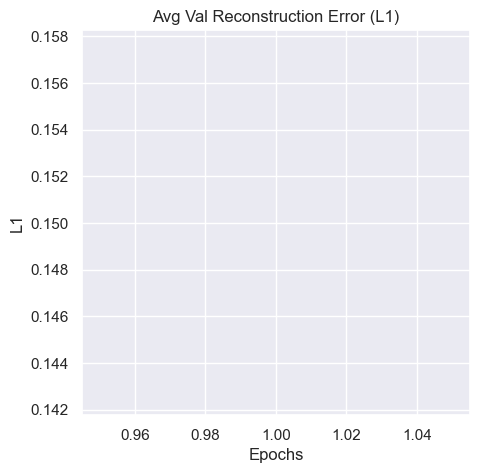

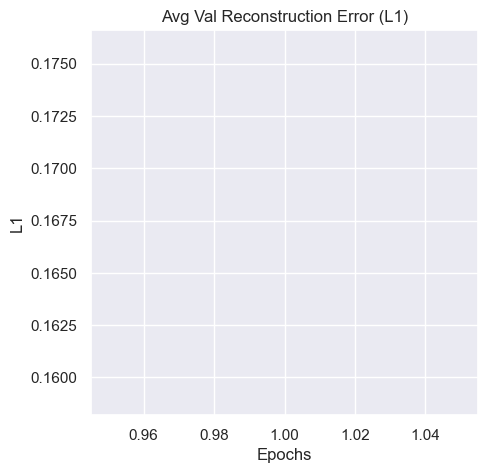

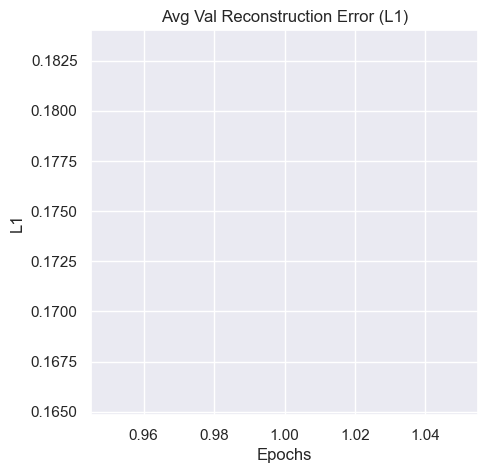

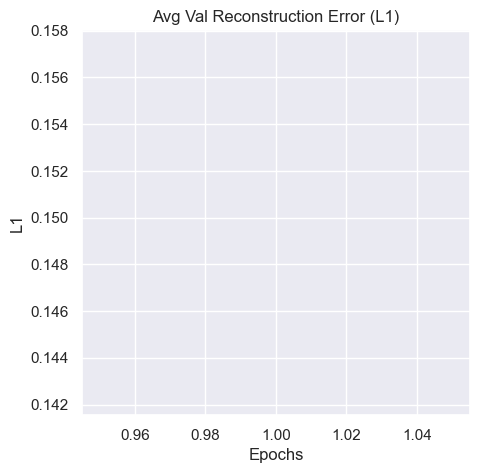

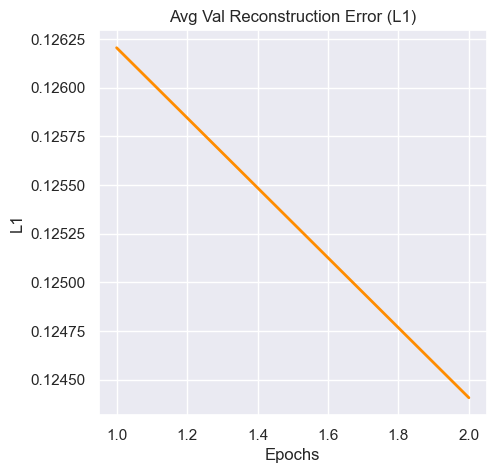

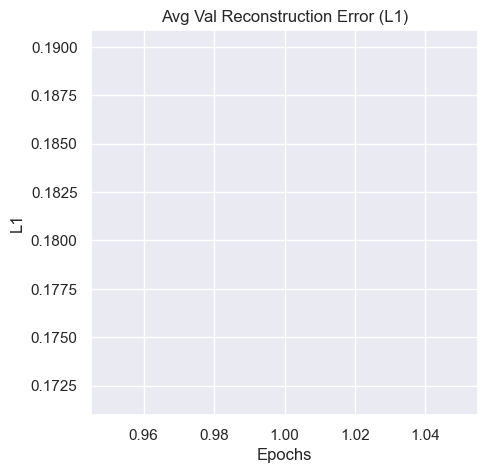

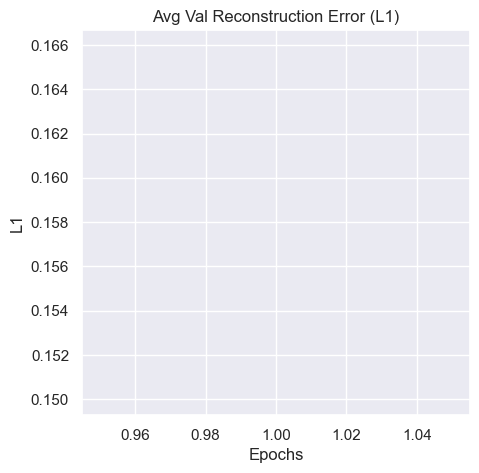

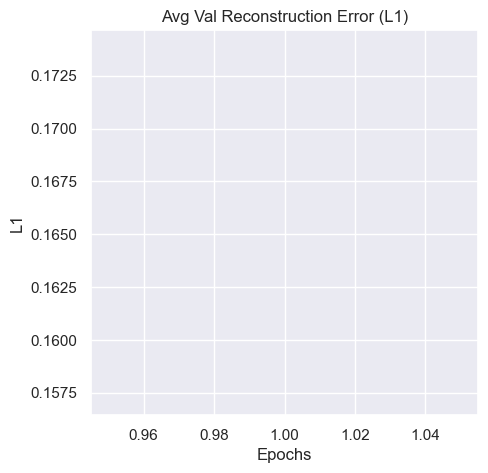

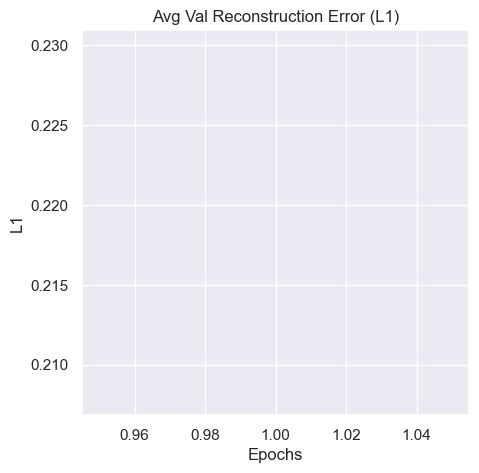

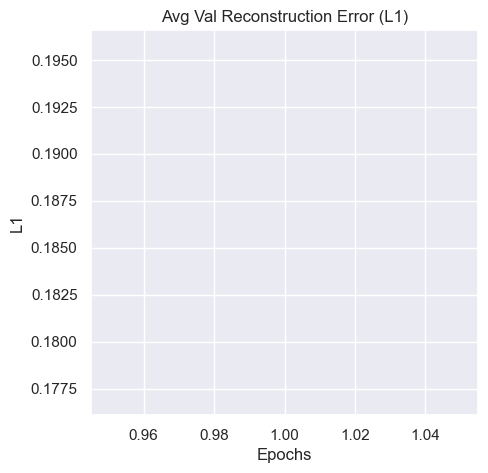

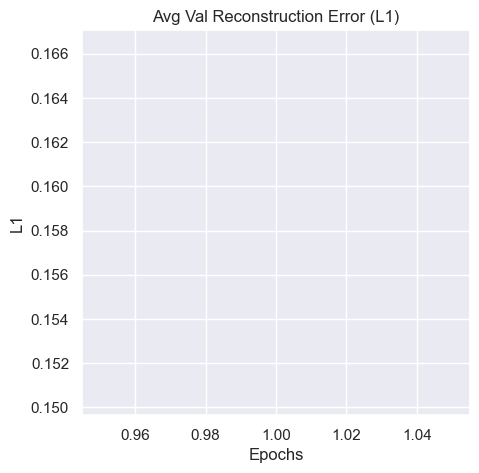

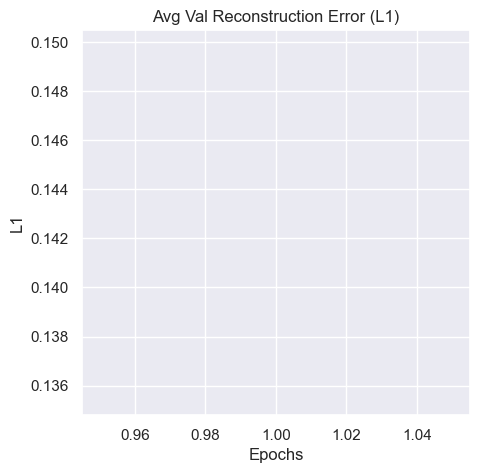

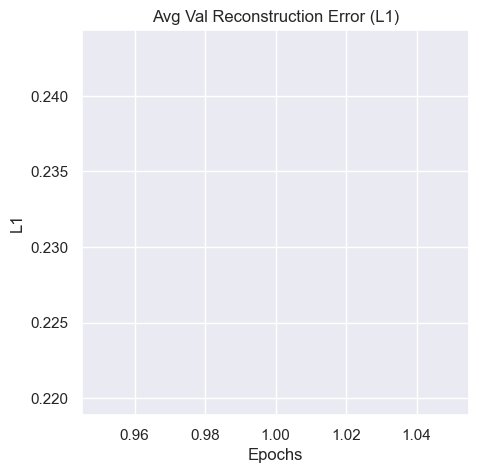

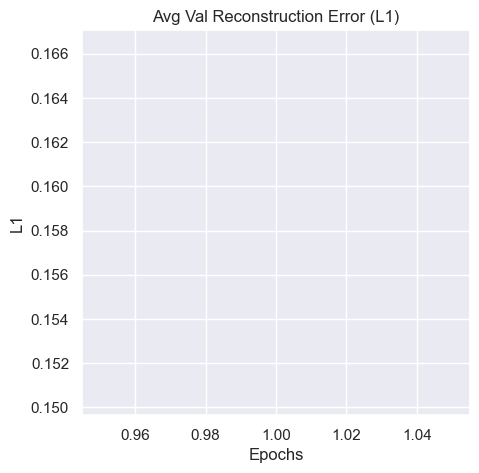

In [62]:
ae_study = optuna.create_study(direction="minimize",study_name="ae_optim_experiment")

ae_study.optimize(objective, n_trials=40,timeout=14400,gc_after_trial=True,show_progress_bar=False)

pruned_trials = ae_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = ae_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(ae_study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = ae_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [90]:
import joblib
joblib.dump(ae_study, "ae_optim_experiment.pkl")

['ae_optim_experiment.pkl']

## Else

In [332]:
study.get_trials()

[FrozenTrial(number=0, values=[0.17428012005984783], datetime_start=datetime.datetime(2022, 11, 22, 4, 23, 23, 895365), datetime_complete=datetime.datetime(2022, 11, 22, 5, 16, 56, 940860), params={'lr': 1.9752807769100706e-05, 'gamma': 0.5}, distributions={'lr': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'gamma': FloatDistribution(high=1.0, log=False, low=0.0, step=0.1)}, user_attrs={}, system_attrs={}, intermediate_values={1: 0.18091042898595333, 2: 0.17428012005984783, 3: 0.1863619852811098, 4: 0.18149468302726746, 5: 0.17864146642386913, 6: 0.177259786054492, 7: 0.17511851713061333, 8: 0.17489653453230858, 9: 0.1751847919076681, 10: 0.17585672996938229}, trial_id=0, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=1, values=[0.09814608283340931], datetime_start=datetime.datetime(2022, 11, 22, 5, 16, 56, 962855), datetime_complete=datetime.datetime(2022, 11, 22, 6, 7, 45, 325352), params={'lr': 0.002086991684709514, 'gamma': 0.4}, distributions={'lr': Fl

In [326]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  4
Best trial:
  Value:  0.09814608283340931
  Params: 
    lr: 0.002086991684709514
    gamma: 0.4


In [330]:
import joblib
joblib.dump(study, "study.pkl")

In [331]:
joblib.dump(study, "study.pkl")

['study.pkl']

In [155]:
import itertools as it

my_dict={'learning_rate':[5e-4,5e-3],'gamma':np.linspace(0,1,10)}
allNames = sorted(my_dict)
combinations = it.product(*(my_dict[Name] for Name in allNames))
print(list(combinations))

[(0.0, 0.0001), (0.0, 0.11120000000000001), (0.0, 0.2223), (0.0, 0.33340000000000003), (0.0, 0.4445), (0.0, 0.5556), (0.0, 0.6667000000000001), (0.0, 0.7778), (0.0, 0.8889), (0.0, 1.0), (0.1111111111111111, 0.0001), (0.1111111111111111, 0.11120000000000001), (0.1111111111111111, 0.2223), (0.1111111111111111, 0.33340000000000003), (0.1111111111111111, 0.4445), (0.1111111111111111, 0.5556), (0.1111111111111111, 0.6667000000000001), (0.1111111111111111, 0.7778), (0.1111111111111111, 0.8889), (0.1111111111111111, 1.0), (0.2222222222222222, 0.0001), (0.2222222222222222, 0.11120000000000001), (0.2222222222222222, 0.2223), (0.2222222222222222, 0.33340000000000003), (0.2222222222222222, 0.4445), (0.2222222222222222, 0.5556), (0.2222222222222222, 0.6667000000000001), (0.2222222222222222, 0.7778), (0.2222222222222222, 0.8889), (0.2222222222222222, 1.0), (0.3333333333333333, 0.0001), (0.3333333333333333, 0.11120000000000001), (0.3333333333333333, 0.2223), (0.3333333333333333, 0.33340000000000003)

In [381]:

encoderdict = dict()
encoderdict['num_layers'] = 4 #14
encoderdict['kernel_size'] = 5
encoderdict['stride'] = 1
encoderdict['padding'] = 0
encoderdict['dilation'] = 1
st_d = torch.load('./models/ae_model_(0.002086991684709514,0.4,4,5,1,0,1,L1).pth')
model = AutoEnc(**encoderdict).to(device)
model.load_state_dict(st_d)

Layer 1 (channels 1 shape 64) -> 16, 60
Layer 2 (channels 16 shape 60) -> 32, 56
Layer 3 (channels 32 shape 56) -> 64, 52
Layer 4 (channels 64 shape 52) -> 64, 48
52 52
Layer 1 (channels 64 shape 48) -> 64, 52
56 56
Layer 2 (channels 64 shape 52) -> 32, 56
60 60
Layer 3 (channels 32 shape 56) -> 16, 60
64 64
Layer 4 (channels 16 shape 60) -> 16, 64


<All keys matched successfully>

In [386]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from custommodels import AutoEnc


encoderdict = dict()
encoderdict['num_layers'] = 3 #14
encoderdict['kernel_size'] = 3
encoderdict['stride'] = 2
encoderdict['padding'] = 0
encoderdict['dilation'] = 1
model = AutoEnc(**encoderdict).to(device)

Layer 1 (channels 1 shape 64) -> 16, 31
Layer 2 (channels 16 shape 31) -> 32, 15
Layer 3 (channels 32 shape 15) -> 64, 7
15 15
Layer 1 (channels 64 shape 7) -> 64, 15
31 31
Layer 2 (channels 64 shape 15) -> 32, 31
63 64
padding now 1
Layer 3 (channels 32 shape 31) -> 16, 64


In [54]:
encoderdict={'num_layers': 3, 'kernel_size': 5, 'stride': 1, 'padding': 2, 'dilation': 1}
from custommodels import AutoEnc
model = AutoEnc(**encoderdict).to(device)

Layer 1 (channels 1 shape 64) -> 16, 64
Layer 2 (channels 16 shape 64) -> 32, 64
Layer 3 (channels 32 shape 64) -> 64, 64
64 64 input 32768 output 128
Layer 1 (channels 64 shape 64) -> 64, 64
Layer 2 (channels 64 shape 64) -> 32, 64
Layer 3 (channels 32 shape 64) -> 16, 64


In [55]:
best_metric = None
best_metric_epoch = -1
max_epochs = 4
val_interval = 1
chosen_loss = "L1"


#max_epochs: 5,10,15,20
#loss: "L1","L2"
#learning rates: 1e4,45

optimizer = torch.optim.Adam(model.parameters(), 5e-4)

if chosen_loss=="L1":
    loss_function = nn.L1Loss()
    score_function = nn.L1Loss(reduction='none')
elif chosen_loss=="L2":
    loss_function = nn.MSELoss()
    score_function = nn.MSELoss(reduction='none')
else:
    raise ValueError(f"chosen loss {chosen_loss} invalid")
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    epoch_loss = train(model,train_loader,optimizer,loss_function)
    print(f"TRAIN: epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            adsa
            loss_values, y_pred,y_mask,y_true = score(model,val_loader,loss_function)
           
            y_stat = score_function(y_pred,y_true)


            y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask, detach=False)])
            #y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
            #y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred)])
            reconstruction_err = np.sum(loss_values)
            avg_reconstruction_err = np.mean(loss_values)
            if best_metric == None or avg_reconstruction_err < best_metric:
                best_metric = avg_reconstruction_err
                best_metric_epoch = epoch + 1
            

            #print(np.unique(y_stat),np.unique(y_mask_np))
            #print("min",torch.min(y_stat),"max",torch.max(y_stat))
            diff_auc,diff_auprc,diceScore,diceThreshold = metrics(y_stat,y_mask_np,"Validation",epoch+1)

            print(
                f"current epoch: {epoch + 1}",
                f"\ncurrent L1 reconstruction error mean: {avg_reconstruction_err:.4f}",
                f"\nAUROC: {diff_auc:.4f}",
                f"\nAUPRC: {diff_auprc:.4f}",
                f"\nDICE score: {diceScore:.4f}",
                f"\nThreshold: {diceThreshold:.4f}",
                f"\nbest L1 reconstruction error mean: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )
print(f"train completed, best_metric: {best_metric:.4f} "f"at epoch: {best_metric_epoch}")
modelsavedloc = os.path.join(root_dir,"ae_model.pth")
torch.save(model.state_dict(), modelsavedloc)
print(f"Saved model at {modelsavedloc}.")

----------
epoch 1/4
torch.Size([256, 16, 64, 64])
torch.Size([256, 16, 64, 64])
torch.Size([256, 16, 64, 64])
torch.Size([256, 32, 64, 64])
torch.Size([256, 32, 64, 64])
torch.Size([256, 32, 64, 64])
torch.Size([256, 64, 64, 64])
torch.Size([256, 64, 64, 64])
torch.Size([256, 64, 64, 64])
torch.Size([256, 8, 64, 64])
torch.Size([256, 32768])
torch.Size([256, 128])
torch.Size([256, 128])
torch.Size([256, 32768])
torch.Size([256, 32768])
torch.Size([256, 8, 64, 64])
torch.Size([256, 64, 64, 64])
torch.Size([256, 64, 64, 64])
torch.Size([256, 64, 64, 64])
torch.Size([256, 64, 64, 64])
torch.Size([256, 32, 64, 64])
torch.Size([256, 32, 64, 64])
torch.Size([256, 32, 64, 64])
torch.Size([256, 16, 64, 64])
torch.Size([256, 16, 64, 64])
torch.Size([256, 16, 64, 64])
torch.Size([256, 1, 64, 64])
1/24, train_loss: 0.3149
torch.Size([256, 16, 64, 64])
torch.Size([256, 16, 64, 64])
torch.Size([256, 16, 64, 64])
torch.Size([256, 32, 64, 64])
torch.Size([256, 32, 64, 64])
torch.Size([256, 32, 64, 6

KeyboardInterrupt: 

<AxesSubplot:>

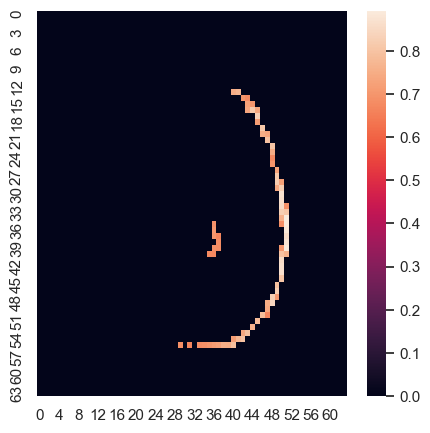

In [154]:
#y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
#prior_quantile = np.quantile(y_true_np, 0.9)
#print("Prior quantile:",prior_quantile)
#y_stat_test = np.copy(y_stat)
#y_stat_test[y_stat_test < prior_quantile] = 0

sns.heatmap(y_stat_test[0][0], annot=False)

In [45]:
loss_function = nn.L1Loss()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEnc()
model.load_state_dict(torch.load('ae_model.pth'))

TypeError: super(type, obj): obj must be an instance or subtype of type

min tensor(7.4506e-09) max tensor(1476.6730)
7.450580596923828e-09 1476.6729736328125
0 1.0 0.1
Trying 0,0.0
Trying 1,0.1
Trying 2,0.2
Trying 3,0.30000000000000004
Trying 4,0.4
0.2 0.4 0.01
Trying 0,0.2
Trying 1,0.21000000000000002
Trying 2,0.22
Trying 3,0.23
Trying 4,0.24000000000000002
Trying 5,0.25
Trying 6,0.26
Trying 7,0.27
Trying 8,0.28
Trying 9,0.29000000000000004
Trying 10,0.30000000000000004
0.28 0.30000000000000004 0.001
Trying 0,0.28
Trying 1,0.281
Trying 2,0.28200000000000003
Trying 3,0.28300000000000003
Trying 4,0.28400000000000003
0.28200000000000003 0.28400000000000003 0.0001
Trying 0,0.28200000000000003
Trying 1,0.2821
Trying 2,0.2822
Trying 3,0.28230000000000005
Trying 4,0.28240000000000004
Trying 5,0.28250000000000003
0.28230000000000005 0.28250000000000003 1e-05
Trying 0,0.28230000000000005
Trying 1,0.28231000000000006
Trying 2,0.28232000000000007
0.28230000000000005 0.28232000000000007 1e-06
Trying 0,0.28230000000000005
Trying 1,0.282301
Trying 2,0.28230200000000005

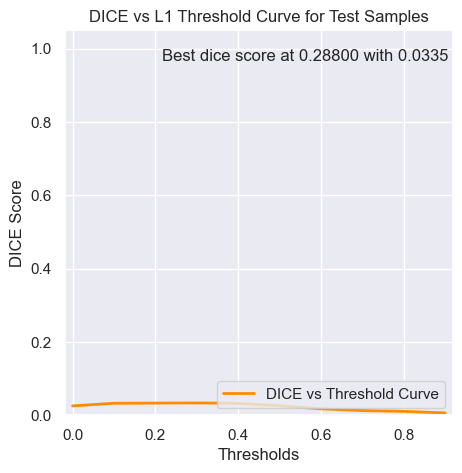

Computing AUROC:


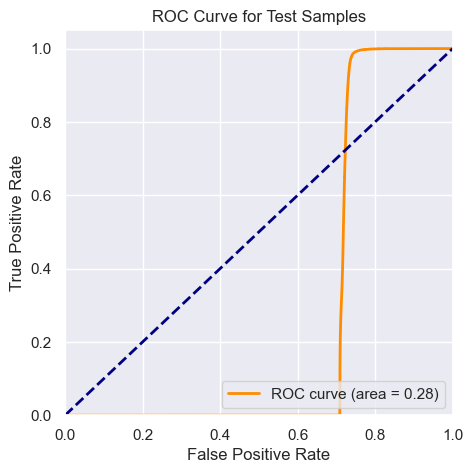

Computing AUPRC:


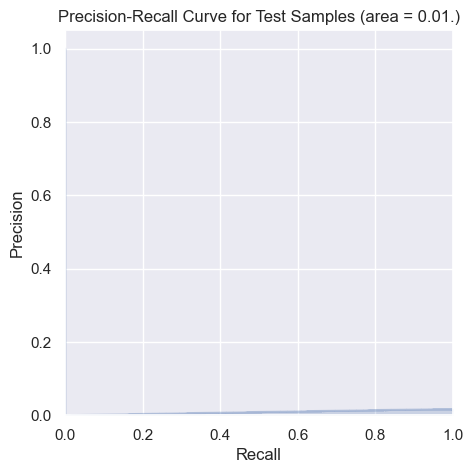

In [183]:
print("min",torch.min(y_stat),"max",torch.max(y_stat))
diff_auc,diff_auprc,diceScore,diceThreshold = metrics(y_stat,y_mask_np,"Test","test")

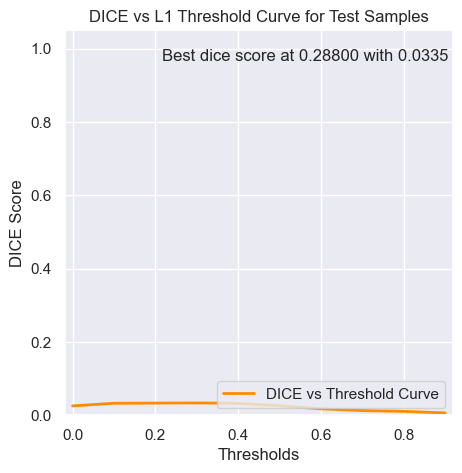

Computing AUROC:


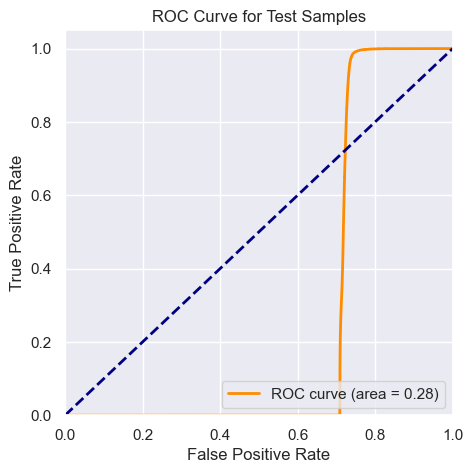

Computing AUPRC:


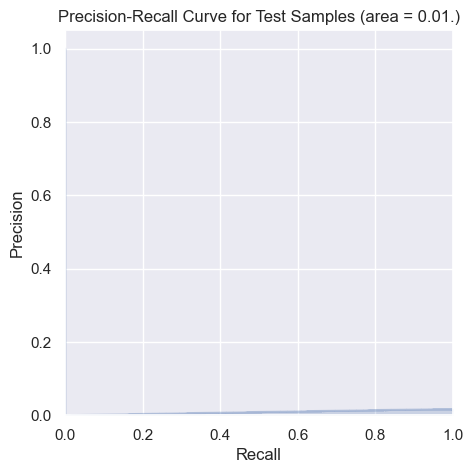


L1 reconstruction error mean: 30.0772 
AUROC: 0.2810 
AUPRC: 0.0089 
DICE score: 0.0335 
Threshold: 0.2880


In [163]:
model.eval()
with torch.no_grad():
    loss_values, y_pred,y_mask,y_true = score(model,test_loader,loss_function)
    
    #y_stat = score_function(y_pred,y_true)
    y_stat = torch.abs(y_true-y_pred)


    y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask, detach=False)])
    #y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
    #y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred)])

    reconstruction_err = np.sum(loss_values)
    avg_reconstruction_err = np.mean(loss_values)
    

    #print(np.unique(y_stat),np.unique(y_mask_np))
    #print("min",torch.min(y_stat),"max",torch.max(y_stat))
    diff_auc,diff_auprc,diceScore,diceThreshold = metrics(y_stat,y_mask_np,"Test","test")

    print(
        f"\nL1 reconstruction error mean: {avg_reconstruction_err:.4f}",
        f"\nAUROC: {diff_auc:.4f}",
        f"\nAUPRC: {diff_auprc:.4f}",
        f"\nDICE score: {diceScore:.4f}",
        f"\nThreshold: {diceThreshold:.4f}",
            )

(6895,) (6895,)
computing dice...


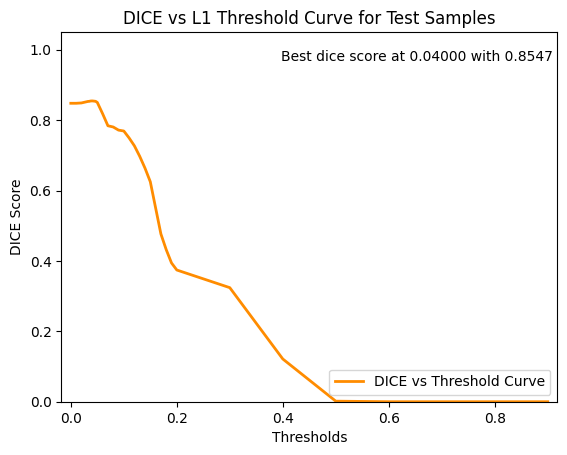

Computing AUROC:


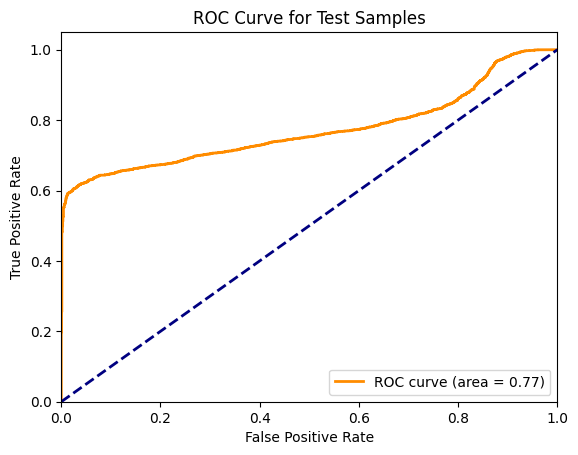

Computing AUPRC:


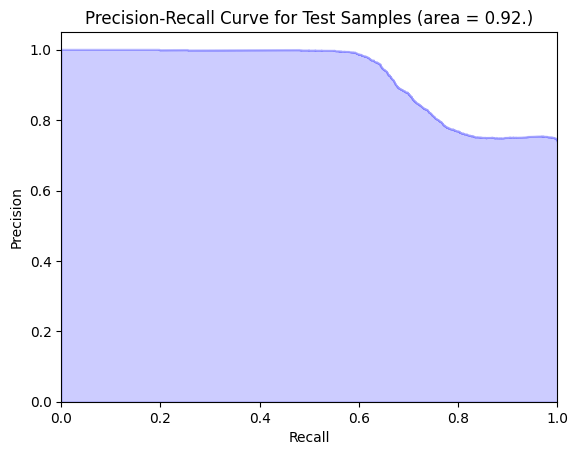

L1 reconstruction error mean: 0.1495 
AUROC: 0.7722 
AUPRC: 0.9248 
DICE score: 0.8547 
Threshold: 0.0400


In [88]:
best_metric = None
test_loss_values = []
model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y_mask = torch.tensor([], dtype=torch.long, device=device)
    y_true = torch.tensor([], dtype=torch.long, device=device)
    val_classes = []
    val_loss_values = []
    #i=0
    for val_data, ground_truths,classification in test_loader:
        val_images = val_data.to(device)
        y_pred = torch.cat([y_pred, model(val_images)], dim=0)
        y_true = torch.cat([y_true, val_images], dim=0)
        y_mask = torch.cat([y_mask, ground_truths], dim=0)
        loss = loss_function(y_pred, y_true)
        val_classes.extend(classification)
        val_loss_values.append(loss.item())
        #print(f"Iter {i+1}:")
        #i+=1
        #if i==3:
        #    break
    y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask, detach=False)])
    y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
    y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred)])

    reconstruction_err = np.sum(val_loss_values)
    avg_reconstruction_err = np.mean(val_loss_values)
    
    img_losses = np.array([loss_function(p,t).item() for p,t in zip(y_pred,y_true)])
    val_classes = np.array(val_classes)
    print(img_losses.shape,val_classes.shape)
    
    folder = "images"
    if not os.path.exists(folder):
        os.mkdir(folder)
    predlabels,diceScore,diceThreshold = compute_dice_curve_recursive(
        img_losses,val_classes,
        plottitle="DICE vs L1 Threshold Curve for Test Samples",
        filename=os.path.join(folder, f'dicePC_test.png'),
        granularity=10
    )


    print("Computing AUROC:")
    diff_auc, _fpr, _tpr, _threshs = compute_roc(img_losses.flatten(), val_classes.astype(bool).flatten(),
                                                                    plottitle="ROC Curve for Test Samples",
                                                                    filename=os.path.join(folder, f'rocPC_test.png'))

    print("Computing AUPRC:")
    diff_auprc, _precisions, _recalls, _threshs = compute_prc(
        img_losses.flatten(),
        val_classes.astype(bool).flatten(),
        plottitle="Precision-Recall Curve for Test Samples",
        filename=os.path.join(folder, f'prcPC_test.png')
    )

    del y_mask_np,y_true_np,y_pred_np
    print(
        f"L1 reconstruction error mean: {avg_reconstruction_err:.4f}",
        f"\nAUROC: {diff_auc:.4f}",
        f"\nAUPRC: {diff_auprc:.4f}",
        f"\nDICE score: {diceScore:.4f}",
        f"\nThreshold: {diceThreshold:.4f}",
    )


In [467]:
h=64
stride=1
padding=0
dilation=1
kernel_size=5
output_padding=0

print((h-1)*stride-2*padding+dilation*(kernel_size-1)+output_padding+1)
print(((h+2*padding-dilation*(kernel_size-1)-1)/(stride))+1)

68
